In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error # <-- IMPORTAR MÉTRICAS
# Regular packages
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsforecast.models import AutoETS
from statsforecast import StatsForecast

# adds src folder to path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

# Nixlaverse model utilities
from hierarchicalforecast.core import HierarchicalReconciliation
# from hierarchicalforecast.evaluation import evaluate
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss, mape
# from statsforecast.models import AutoETS
# from statsforecast import StatsForecast



# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="bright",
    context="notebook"
)

c:\Users\Dog\AppData\Local\Programs\Python\Python313\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


Carregar Banco de Dados.

In [2]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

Filtrar viajens com destino ao Rio de Janeiro

In [3]:
df_rj = process_df(
    df=df,
    state="rio_de_janeiro",
    value_cols="arrivals",
    agg_func="sum",
    agg_cols="date"
)
df_rj.tail()

,date,arrivals
295,2024-08-01,91504.0
296,2024-09-01,116003.0
297,2024-10-01,130985.0
298,2024-11-01,145148.0
299,2024-12-01,176121.0


Criar banco de dados para análise temporal

In [4]:
df_rj_unico = df_rj.set_index('date').copy()
data_series = df_rj_unico['arrivals']
data_series

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Name: arrivals, Length: 300, dtype: float64

Definir Período da covid.

In [5]:
PRE_COVID_END = '2020-02-29' # Último dia antes do impacto
COVID_START = '2020-03-01' # Primeiro dia do impacto
COVID_END = '2022-02-28'   # Último dia do período a ser imputado
dados_pre_covid = data_series.loc[:PRE_COVID_END].copy()

Projetar Componente Sazonalidade, Tendência e Combiná-los para imputar o período da covid

In [6]:
stl = STL(dados_pre_covid, period=12, seasonal=13).fit()

ultimo_ano_sazonal = stl.seasonal[-12:]
indice_gap_covid = data_series.loc[COVID_START:COVID_END].index
n_meses_gap = len(indice_gap_covid)

n_repeticoes = int(np.ceil(n_meses_gap / 12))
valores_sazonais_projetados = np.tile(ultimo_ano_sazonal.values, n_repeticoes)[:n_meses_gap]

sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap_covid)


segmento_tendencia_recente = stl.trend.dropna().iloc[-12:]

x = np.arange(len(segmento_tendencia_recente))
y = segmento_tendencia_recente.values
coefs = np.polyfit(x, y, 1) # Retorna [slope, intercept]
slope = coefs[0]

ultimo_valor_tendencia = segmento_tendencia_recente.iloc[-1]
x_projecao = np.arange(1, n_meses_gap + 1)
valores_tendencia_projetados = (slope * x_projecao) + ultimo_valor_tendencia

tendencia_imputada = pd.Series(valores_tendencia_projetados, index=indice_gap_covid)


valores_imputados = tendencia_imputada + sazonal_imputado
data_series_imputada = data_series.copy()
data_series_imputada.loc[COVID_START:COVID_END] = valores_imputados
data_series_imputada

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Name: arrivals, Length: 300, dtype: float64

Plot da Comparação da Imputação com o Período Original.

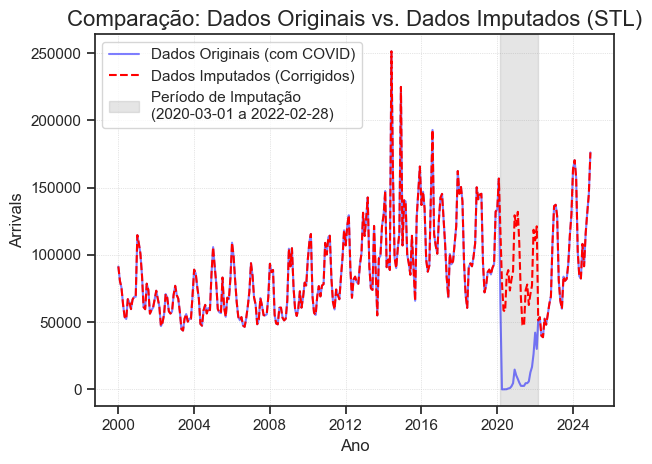

In [7]:
plt.plot(data_series.index, data_series, label='Dados Originais (com COVID)', 
         color='blue', alpha=0.5)

# Plota os novos dados imputados
plt.plot(data_series_imputada.index, data_series_imputada, 
         label='Dados Imputados (Corrigidos)', 
         color='red', linestyle='--')

# Destaca a área que foi imputada
plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
            color='gray', alpha=0.2, label=f'Período de Imputação\n({COVID_START} a {COVID_END})')

plt.title('Comparação: Dados Originais vs. Dados Imputados (STL)', fontsize=16)
plt.ylabel(data_series.name.capitalize() if data_series.name else 'Valores')
plt.xlabel('Ano')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

ETS Python

RMSE (2024): 32361.63
MAPE (2024): 19.97%


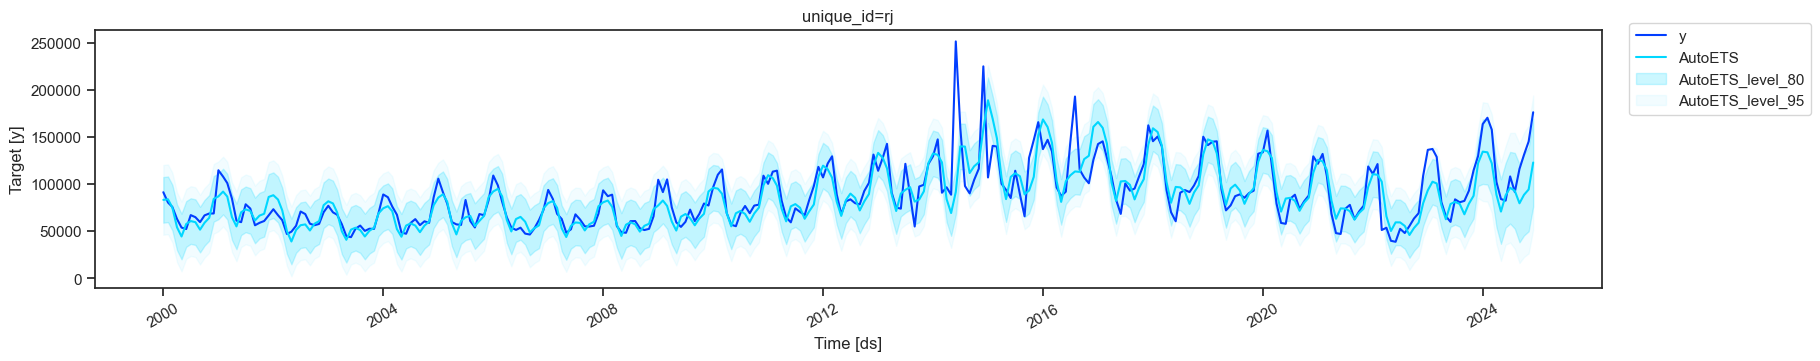

In [8]:
# Treino até 2023-12-31 e teste em 2024, treino ETS via AutoETS (statsforecast) e previsão
train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-12-31'

# Série de treino e teste a partir da série já imputada
train_series = data_series_imputada.loc[:train_end].copy()
test_series = data_series_imputada.loc[test_start:test_end].copy()

# Prepara DataFrame no formato esperado pelo StatsForecast (unique_id, ds, y)
df_sf = pd.DataFrame({
    'unique_id': 'rj',
    'ds': train_series.index,
    'y': train_series.values
})

# Inicializa o objeto StatsForecast com AutoETS
sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)

sf.fit(df=df_sf)

# Chamada correta: passar o DataFrame como argumento para forecast()
forecasts = sf.forecast(df=df_sf, h=12, level=[80,95], fitted=True)

# Identifica a coluna de previsão (pode variar de nome conforme versão)
pred_col = [c for c in forecasts.columns if c not in ('unique_id', 'ds')][0]

# Series de previsão alinhada com as datas do horizonte
pred_index = pd.to_datetime(forecasts['ds'])
y_pred = forecasts[pred_col].values

# Valores observados (verdadeiros) para 2024 alinhados com o índice de previsão
y_true = test_series.reindex(pred_index).values

# Métricas
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"RMSE (2024): {rmse_val:.2f}")
print(f"MAPE (2024): {mape_val:.2f}%")

forecasts.head()

fitted = sf.forecast_fitted_values()

# Colunas a serem removidas do dataframe 'fitted'
cols_to_drop = ["y", "SES-lo-95", "SES-hi-95", "SES-lo-80", "SES-hi-80"]
# Remove apenas as colunas que existem
existing_cols_to_drop = [col for col in cols_to_drop if col in fitted.columns]
fitted_clean = fitted.drop(columns=existing_cols_to_drop)

# Prepara os dataframes para o plot_series
Y_df = data_series_imputada.reset_index()
Y_df.columns = ['ds', 'y']
Y_df['unique_id'] = 'rj'

Y_hat_df = pd.concat([forecasts, fitted_clean])

plot_series(
    Y_df,
    Y_hat_df,
    level=[80, 95],
)

Calcula o MAPE dos outros modelos.

In [9]:
# Define os componentes do modelo ETS para iterar
error_options = ['A', 'M']
trend_options = ['N', 'A', 'M']
seasonal_options = ['N', 'A', 'M']
damped_options = [False, True]

# Prepara os dados de treino e teste
train_df = pd.DataFrame({
    'unique_id': 'rj',
    'ds': data_series_imputada.loc[:train_end].index,
    'y': data_series_imputada.loc[:train_end].values
})
test_series = data_series_imputada.loc[test_start:test_end]
h = 12

results = []

# Itera sobre todas as combinações de modelos ETS
for error in error_options:
    for trend in trend_options:
        for seasonal in seasonal_options:
            # A tendência amortecida só se aplica se houver tendência
            damped_iterable = damped_options if trend in ['A', 'M'] else [False]
            for damped in damped_iterable:
                model_str = f"{error}{trend}{seasonal}"
                model_name = f"ETS({model_str}) Damped={damped}"
                
                try:
                    # Inicializa o modelo AutoETS com a configuração específica
                    sf = StatsForecast(models=[AutoETS(season_length=12, model=model_str, damped=damped)], freq='MS', n_jobs=1)

                    # Treina e faz a previsão
                    forecast_df = sf.forecast(h=h, df=train_df)
                    
                    # Extrai a previsão
                    forecast = forecast_df.AutoETS

                    # Calcula o MAPE
                    mape = mean_absolute_percentage_error(test_series, forecast) * 100

                    # Armazena os resultados
                    results.append({
                        'model': model_name,
                        'mape': mape,
                        'forecast': pd.Series(forecast, index=test_series.index)
                    })
                    print(f"Modelo {model_name} - MAPE: {mape:.2f}")

                except Exception as e:
                    print(f"Erro ao treinar o modelo {model_name}: {e}")
                    results.append({'model': model_name, 'mape': float('inf'), 'forecast': None})

Modelo ETS(ANN) Damped=False - MAPE: 25.52
Modelo ETS(ANA) Damped=False - MAPE: 21.07
Erro ao treinar o modelo ETS(ANM) Damped=False: Forbidden model combination
Modelo ETS(AAN) Damped=False - MAPE: 25.67
Modelo ETS(AAN) Damped=True - MAPE: 25.52
Modelo ETS(AAA) Damped=False - MAPE: 18.89
Modelo ETS(AAA) Damped=True - MAPE: 21.11
Erro ao treinar o modelo ETS(AAM) Damped=False: Forbidden model combination
Erro ao treinar o modelo ETS(AAM) Damped=True: Forbidden model combination
Erro ao treinar o modelo ETS(AMN) Damped=False: Forbidden model combination
Erro ao treinar o modelo ETS(AMN) Damped=True: Forbidden model combination
Erro ao treinar o modelo ETS(AMA) Damped=False: Forbidden model combination
Erro ao treinar o modelo ETS(AMA) Damped=True: Forbidden model combination
Erro ao treinar o modelo ETS(AMM) Damped=False: Forbidden model combination
Erro ao treinar o modelo ETS(AMM) Damped=True: Forbidden model combination
Modelo ETS(MNN) Damped=False - MAPE: 26.03
Modelo ETS(MNA) Dampe

Concatena os continentes

In [10]:
df_rj_continente = process_df(df=df, state="rio_de_janeiro", agg_cols=["date","continent","continent_id"], value_cols="arrivals", agg_func="sum")
df_rj_continente.tail()

,date,continent,continent_id,arrivals
2095,2024-12-01,america_do_norte,3,29679.0
2096,2024-12-01,america_do_sul,4,99840.0
2097,2024-12-01,asia,5,2651.0
2098,2024-12-01,europa,6,39981.0
2099,2024-12-01,oceania,7,1623.0


Separa os continentes

In [11]:
# Pivota o dataframe para que cada continente seja uma coluna, com a data como índice
df_continentes_pivot = df_rj_continente.pivot(
    index='date', 
    columns='continent', 
    values='arrivals'
)

# Cria um dicionário onde cada chave é o nome de um continente e o valor é a série temporal correspondente
series_por_continente = {
    continente: df_continentes_pivot[continente] for continente in df_continentes_pivot.columns
}

# Exibe as primeiras 5 linhas do dataframe pivotado para verificação
print("DataFrame Pivotado (cada coluna é uma série temporal):")
print(df_continentes_pivot.head())

# Exemplo de como acessar uma série temporal específica (ex: Europa)
print("\nExemplo de acesso à série da Europa:")
print(series_por_continente['europa'].head())

DataFrame Pivotado (cada coluna é uma série temporal):
continent   africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

continent   america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  

Exemplo de acesso à série da Europa:
date
2000-01-01    41142.0
2000-02-01    36330.0
2000-03-01

Imputando período COVID/Continente

            africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

            america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  


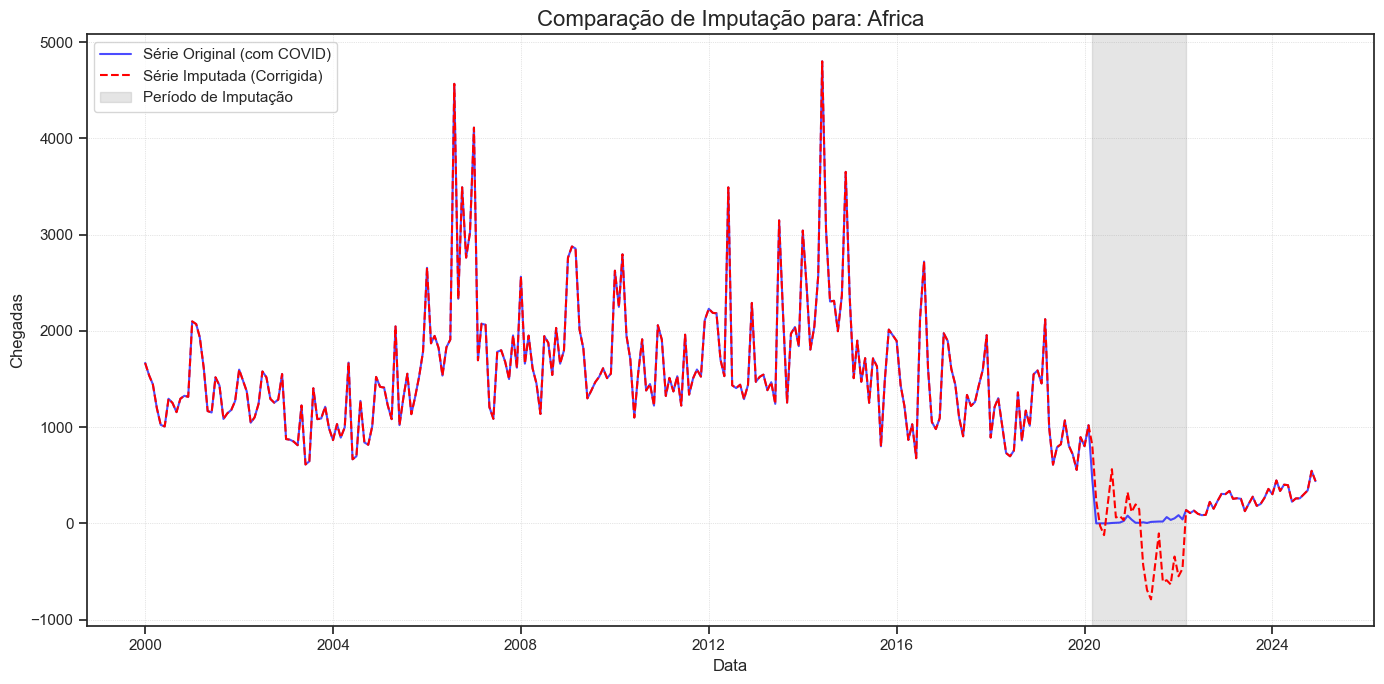

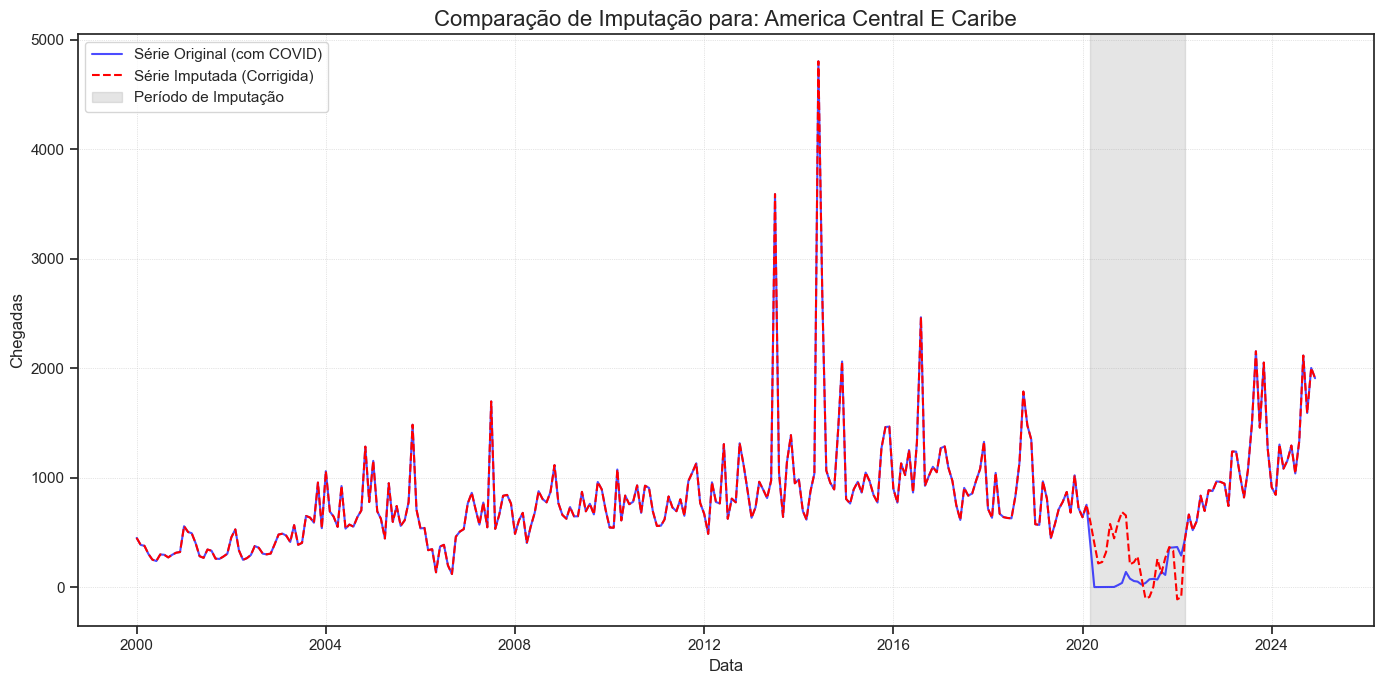

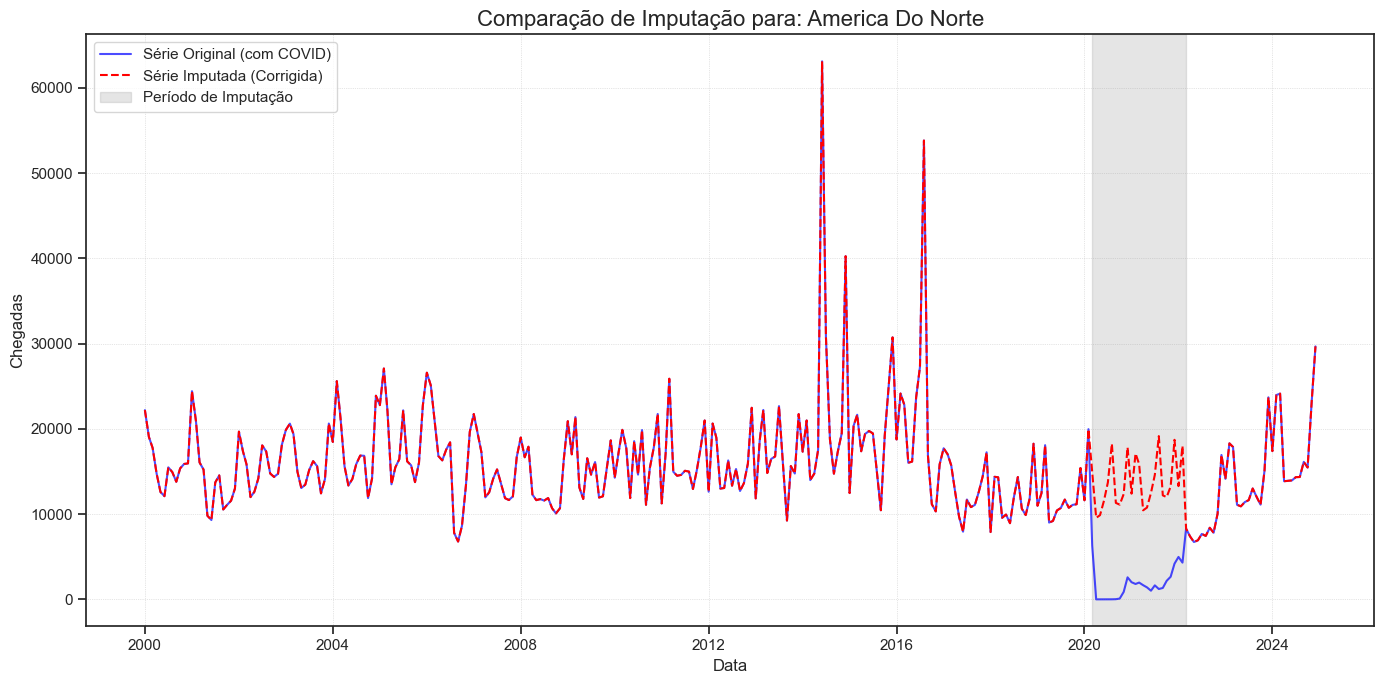

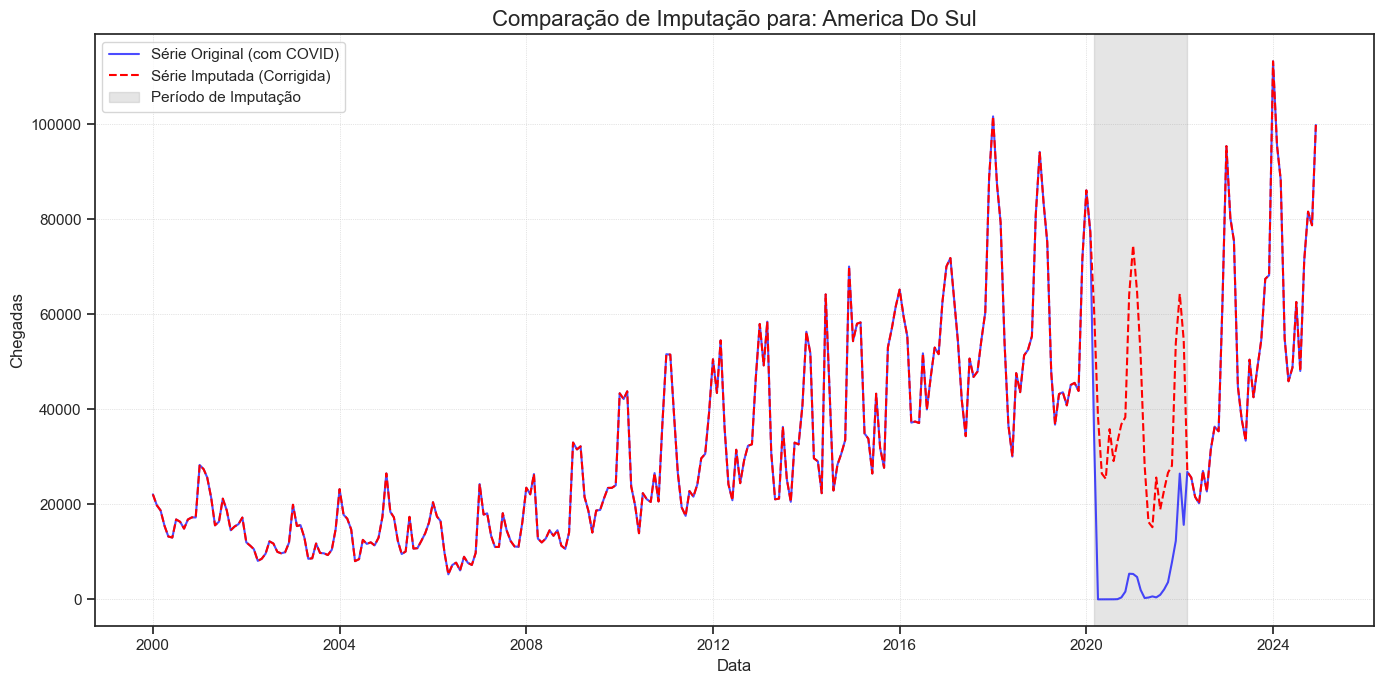

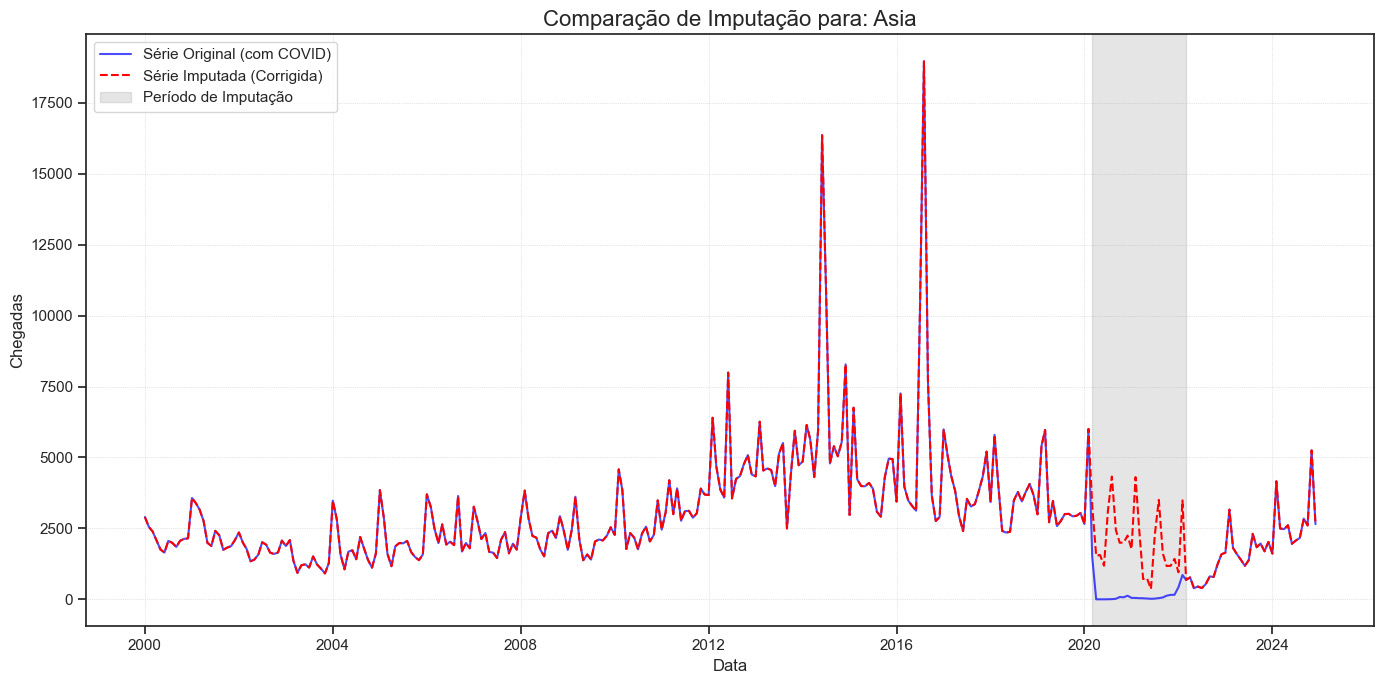

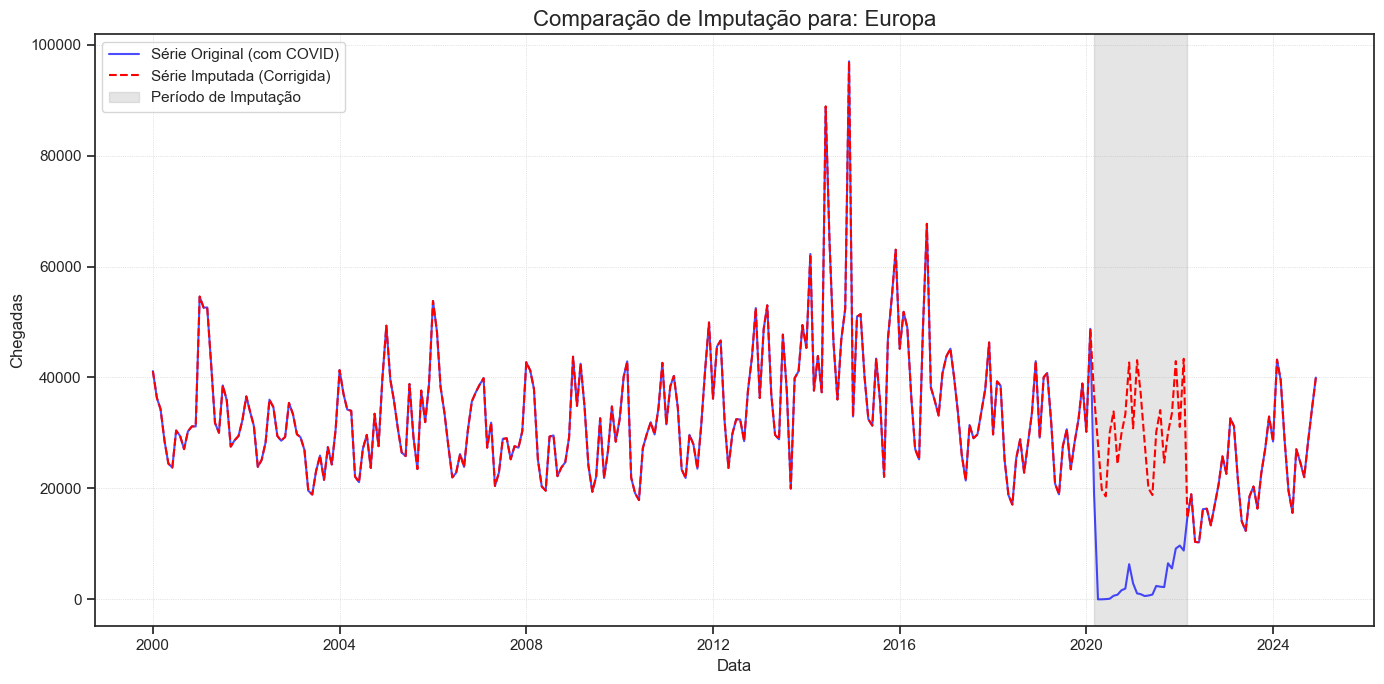

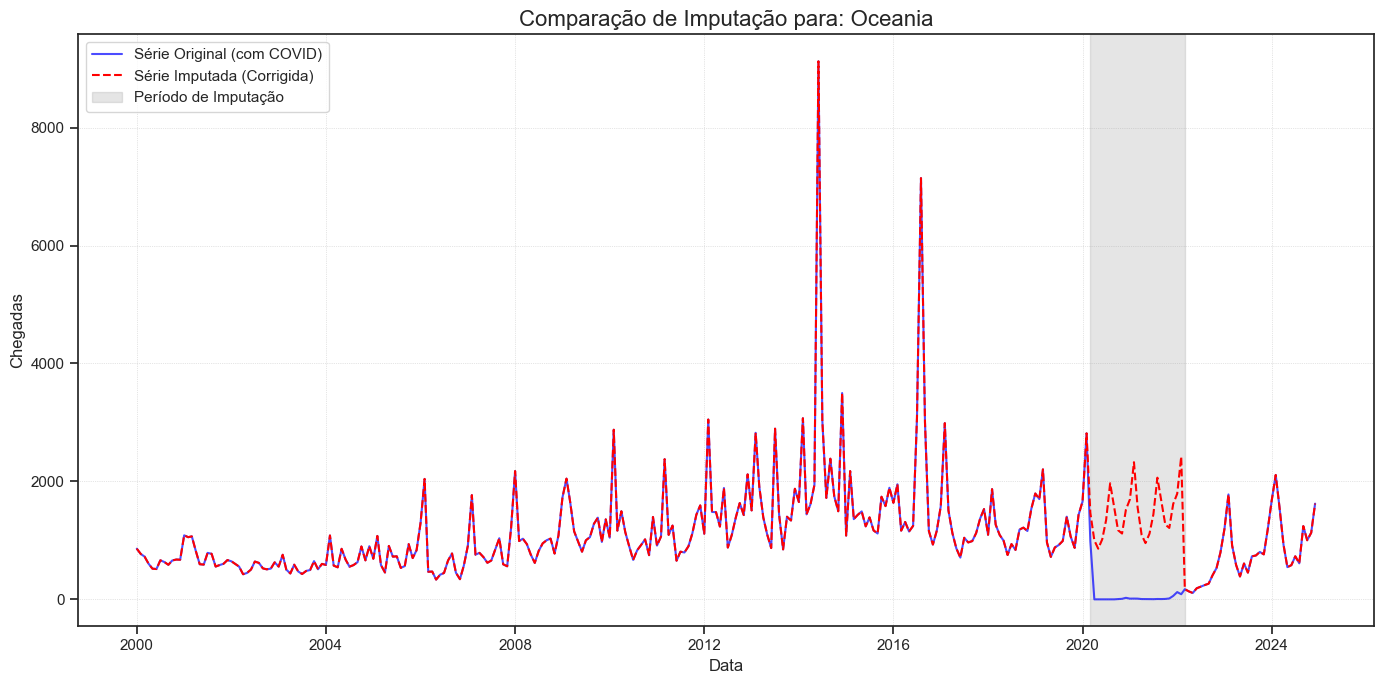

In [12]:
# Imputação do período COVID para cada continente (mesma lógica usada anteriormente)
imputed_continent_series = {}

for continente, serie in series_por_continente.items():
    s = serie.copy()
    # intervalo do gap segundo a série (preserva índice exato)
    indice_gap = s.loc[COVID_START:COVID_END].index
    n_meses_gap = len(indice_gap)
    if n_meses_gap == 0:
        imputed_continent_series[continente] = s
        continue

    # usa apenas pré-COVID para ajustar STL
    pre_covid = s.loc[:PRE_COVID_END].dropna()
    try:
        stl_c = STL(pre_covid, period=12, seasonal=13).fit()

        # componente sazonal: repete o último ano sazonal conforme necessário
        ultimo_ano_sazonal = stl_c.seasonal[-12:]
        n_repeticoes = int(np.ceil(n_meses_gap / 12))
        valores_sazonais_projetados = np.tile(ultimo_ano_sazonal.values, n_repeticoes)[:n_meses_gap]
        sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap)

        # componente tendência: ajusta reta ao último segmento de tendência (12 meses) e projeta
        segmento_tendencia_recente = stl_c.trend.dropna().iloc[-12:]
        x = np.arange(len(segmento_tendencia_recente))
        y = segmento_tendencia_recente.values
        coefs = np.polyfit(x, y, 1)  # [slope, intercept]
        slope = coefs[0]
        ultimo_valor_tendencia = segmento_tendencia_recente.iloc[-1]
        x_projecao = np.arange(1, n_meses_gap + 1)
        valores_tendencia_projetados = (slope * x_projecao) + ultimo_valor_tendencia
        tendencia_imputada = pd.Series(valores_tendencia_projetados, index=indice_gap)

        # soma tendência + sazonal para obter imputação
        valores_imputados = tendencia_imputada + sazonal_imputado

        s_imputada = s.copy()
        s_imputada.loc[COVID_START:COVID_END] = valores_imputados
        imputed_continent_series[continente] = s_imputada

    except Exception as e:
        # se falhar, mantém a série original e informa
        print(f"Erro ao imputar {continente}: {e}")
        imputed_continent_series[continente] = s

# Monta DataFrame pivotado com séries imputadas (mesmo formato de df_continentes_pivot)
df_continentes_pivot_imputado = pd.DataFrame(imputed_continent_series).sort_index()
df_continentes_pivot_imputado.index.name = 'date'

# Converte para formato longo (ds, unique_id, y) compatível com Y_df_h
Y_df_h_imputado = (
    df_continentes_pivot_imputado
    .reset_index()
    .melt(id_vars='date', var_name='unique_id', value_name='y')
    .rename(columns={'date': 'ds'})
)

# Saída rápida para verificação
print(df_continentes_pivot_imputado.head())

# Plot da comparação para cada continente
for continente, serie_imputada in imputed_continent_series.items():
    serie_original = series_por_continente[continente]
    
    plt.figure(figsize=(14, 7))
    
    # Plota a série original
    plt.plot(serie_original.index, serie_original.values, 
             label='Série Original (com COVID)', color='blue', alpha=0.7)
    
    # Plota a série imputada
    plt.plot(serie_imputada.index, serie_imputada.values, 
             label='Série Imputada (Corrigida)', color='red', linestyle='--')
    
    # Destaca o período de imputação
    plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
                color='gray', alpha=0.2, label=f'Período de Imputação')
    
    # Configurações do gráfico
    plt.title(f'Comparação de Imputação para: {continente.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Chegadas', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

ETS Continente

In [20]:
# Lista para armazenar os resultados de cada continente
continent_forecast_results = []

# Horizonte de previsão
h = 12

# Itera sobre cada continente único no dataframe imputado
for continent_name in Y_df_h_imputado['unique_id'].unique():
    print(f"--- Processando: {continent_name.capitalize()} ---")
    
    # Filtra os dados de treino e teste para o continente atual
    train_df_continent = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continent_name) & 
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    
    # Usa a série original (não imputada) para o período de teste para avaliação
    test_series_continent = series_por_continente[continent_name].loc[test_start:test_end]

    # Garante que há dados de teste para avaliar
    if test_series_continent.empty:
        print(f"Sem dados de teste para {continent_name}. Pulando.")
        continue

    y_true_continent = test_series_continent.values

    try:
        # Inicializa e treina o modelo AutoETS
        sf_continent = StatsForecast(
            models=[AutoETS(season_length=12)], 
            freq='MS', 
            n_jobs=1
        )
        sf_continent.fit(df=train_df_continent)

        # Gera a previsão com intervalos de confiança
        forecast_df = sf_continent.forecast(df=train_df_continent, h=h, level=[80, 95])
        
        # Extrai os valores previstos
        y_pred_continent = forecast_df['AutoETS'].values

        # Calcula o MAPE
        mape_continent = mean_absolute_percentage_error(y_true_continent, y_pred_continent) * 100

        # Armazena os resultados, incluindo o dataframe de previsão completo
        continent_forecast_results.append({
            'continent': continent_name,
            'mape': mape_continent,
            'forecast': forecast_df.set_index('ds') # Armazena o dataframe com índice de data
        })
        
        print(f"Modelo AutoETS para {continent_name.capitalize()} - MAPE: {mape_continent:.2f}%")

    except Exception as e:
        print(f"Erro ao treinar o modelo para {continent_name.capitalize()}: {e}")
        continent_forecast_results.append({
            'continent': continent_name, 
            'mape': float('inf'), 
            'forecast': None
        })

# Converte a lista de resultados em um DataFrame para fácil visualização
results_df = pd.DataFrame(continent_forecast_results).sort_values(by='mape').reset_index(drop=True)
print("\n--- Resultados Finais (MAPE por Continente) ---")
print(results_df[['continent', 'mape']])
continent_forecast_results = []

--- Processando: Africa ---
Modelo AutoETS para Africa - MAPE: 55.65%
--- Processando: America_central_e_caribe ---
Modelo AutoETS para America_central_e_caribe - MAPE: 29.87%
--- Processando: America_do_norte ---
Modelo AutoETS para America_do_norte - MAPE: 22.69%
--- Processando: America_do_sul ---
Modelo AutoETS para America_do_sul - MAPE: 14.99%
--- Processando: Asia ---
Modelo AutoETS para Asia - MAPE: 31.65%
--- Processando: Europa ---
Modelo AutoETS para Europa - MAPE: 17.35%
--- Processando: Oceania ---
Modelo AutoETS para Oceania - MAPE: 44.66%

--- Resultados Finais (MAPE por Continente) ---
                  continent       mape
0            america_do_sul  14.992188
1                    europa  17.354773
2          america_do_norte  22.688645
3  america_central_e_caribe  29.874948
4                      asia  31.646684
5                   oceania  44.661680
6                    africa  55.653110


In [19]:
# Horizonte de previsão
h = 12

# Itera sobre cada continente único no dataframe imputado
for continent_name in Y_df_h_imputado['unique_id'].unique():
    print(f"--- Processando: {continent_name.capitalize()} ---")
    
    # Filtra os dados de treino e teste para o continente atual
    train_df_continent = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continent_name) & 
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    
    test_df_continent = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continent_name) & 
        (Y_df_h_imputado['ds'] >= test_start)
    ].copy()

    # Garante que há dados de teste para avaliar
    if test_df_continent.empty:
        print(f"Sem dados de teste para {continent_name}. Pulando.")
        continue

    y_true_continent = test_df_continent['y'].values

    try:
        # Inicializa e treina o modelo AutoETS
        sf_continent = StatsForecast(
            models=[AutoETS(season_length=12)], 
            freq='MS', 
            n_jobs=1
        )
        sf_continent.fit(df=train_df_continent)

        # Gera a previsão
        forecast_df = sf_continent.forecast(df=train_df_continent, h=h)
        
        # Extrai os valores previstos
        y_pred_continent = forecast_df['AutoETS'].values

        # Calcula o MAPE
        mape_continent = mean_absolute_percentage_error(y_true_continent, y_pred_continent) * 100

        # Armazena os resultados
        continent_forecast_results.append({
            'continent': continent_name,
            'mape': mape_continent,
            'forecast': pd.Series(y_pred_continent, index=test_df_continent['ds'])
        })
        
        print(f"Modelo AutoETS para {continent_name.capitalize()} - MAPE: {mape_continent:.2f}%")

    except Exception as e:
        print(f"Erro ao treinar o modelo para {continent_name.capitalize()}: {e}")
        continent_forecast_results.append({
            'continent': continent_name, 
            'mape': float('inf'), 
            'forecast': None
        })

# Converte a lista de resultados em um DataFrame para fácil visualização
results_df = pd.DataFrame(continent_forecast_results).sort_values(by='mape').reset_index(drop=True)
print("\n--- Resultados Finais (MAPE por Continente) ---")
print(results_df[['continent', 'mape']])

--- Processando: Africa ---
Modelo AutoETS para Africa - MAPE: 55.65%
--- Processando: America_central_e_caribe ---
Modelo AutoETS para America_central_e_caribe - MAPE: 29.87%
--- Processando: America_do_norte ---
Modelo AutoETS para America_do_norte - MAPE: 22.69%
--- Processando: America_do_sul ---
Modelo AutoETS para America_do_sul - MAPE: 14.99%
--- Processando: Asia ---
Modelo AutoETS para Asia - MAPE: 31.65%
--- Processando: Europa ---
Modelo AutoETS para Europa - MAPE: 17.35%
--- Processando: Oceania ---
Modelo AutoETS para Oceania - MAPE: 44.66%

--- Resultados Finais (MAPE por Continente) ---
                  continent       mape
0            america_do_sul  14.992188
1                    europa  17.354773
2          america_do_norte  22.688645
3  america_central_e_caribe  29.874948
4                      asia  31.646684
5                   oceania  44.661680
6                    africa  55.653110


Plot Continente

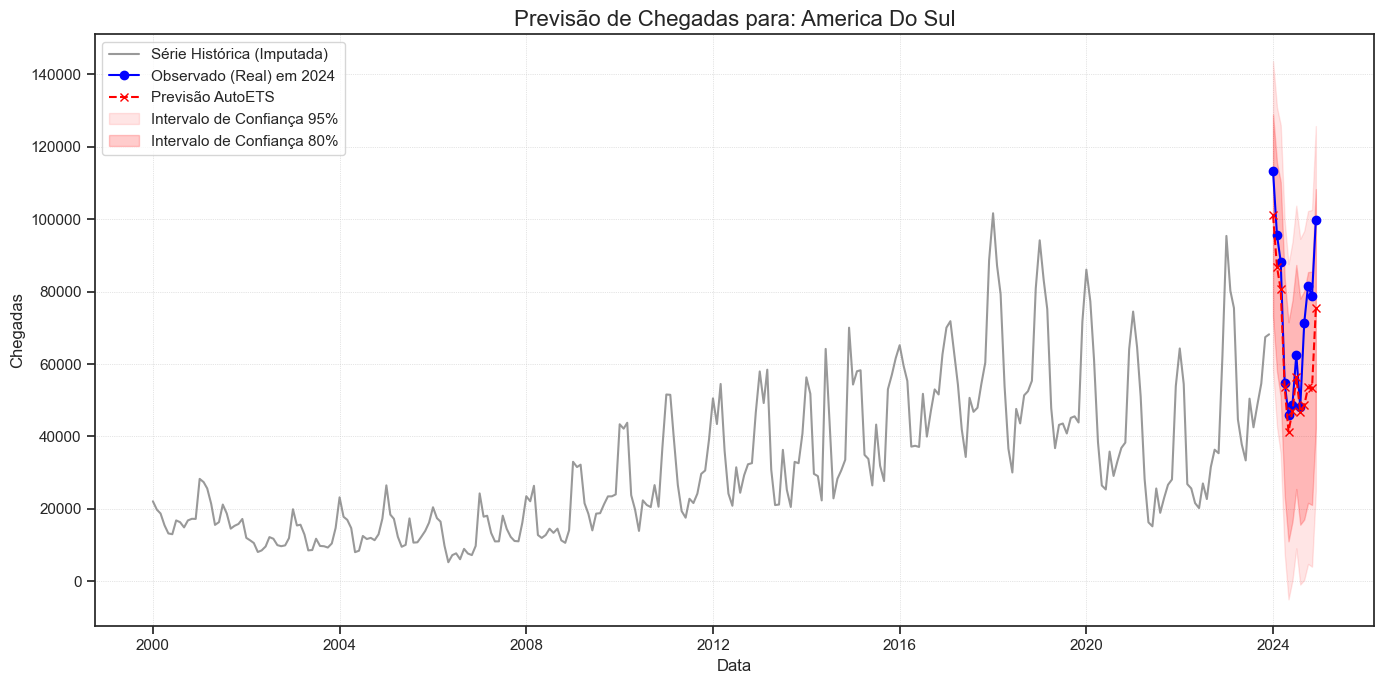

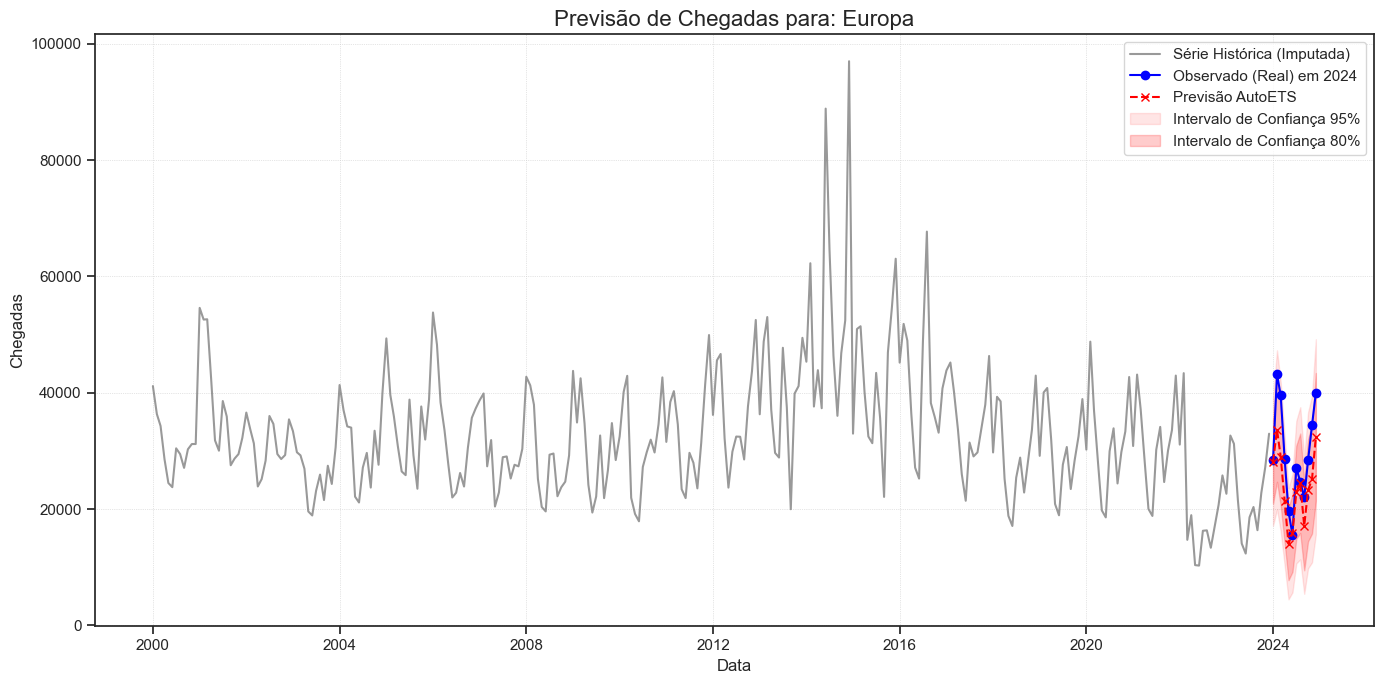

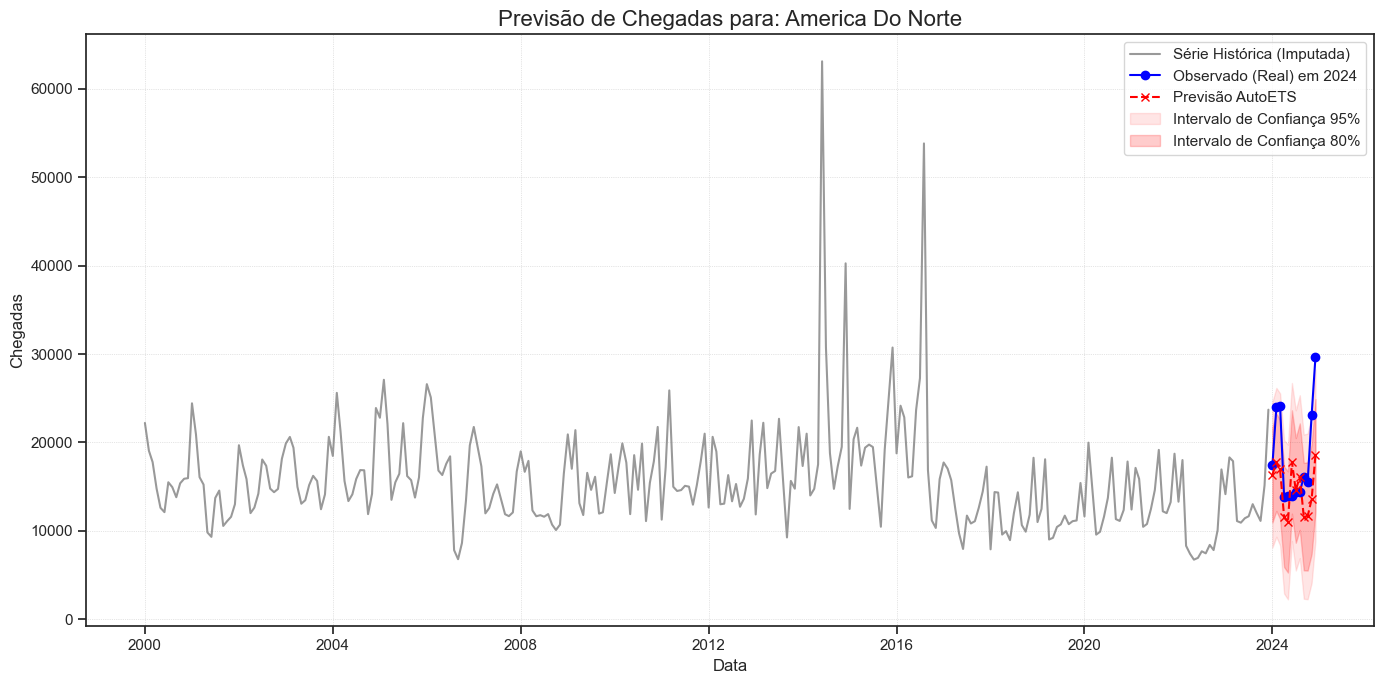

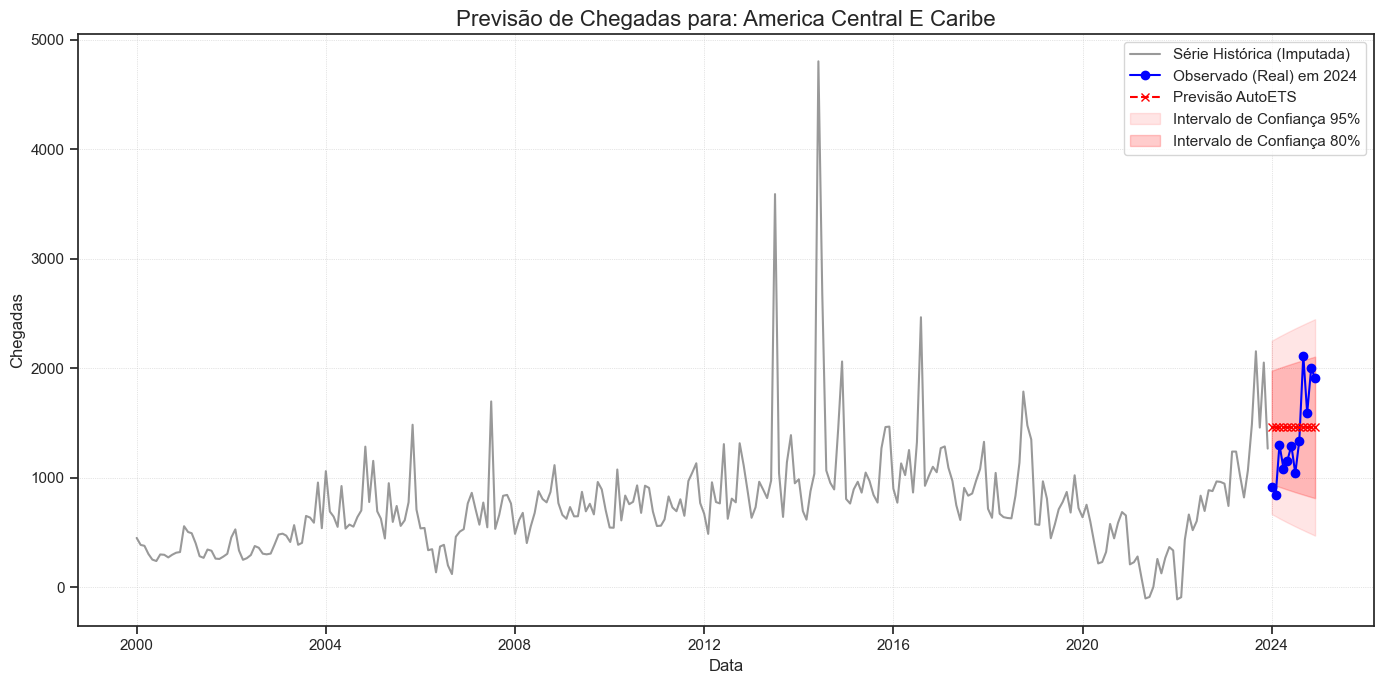

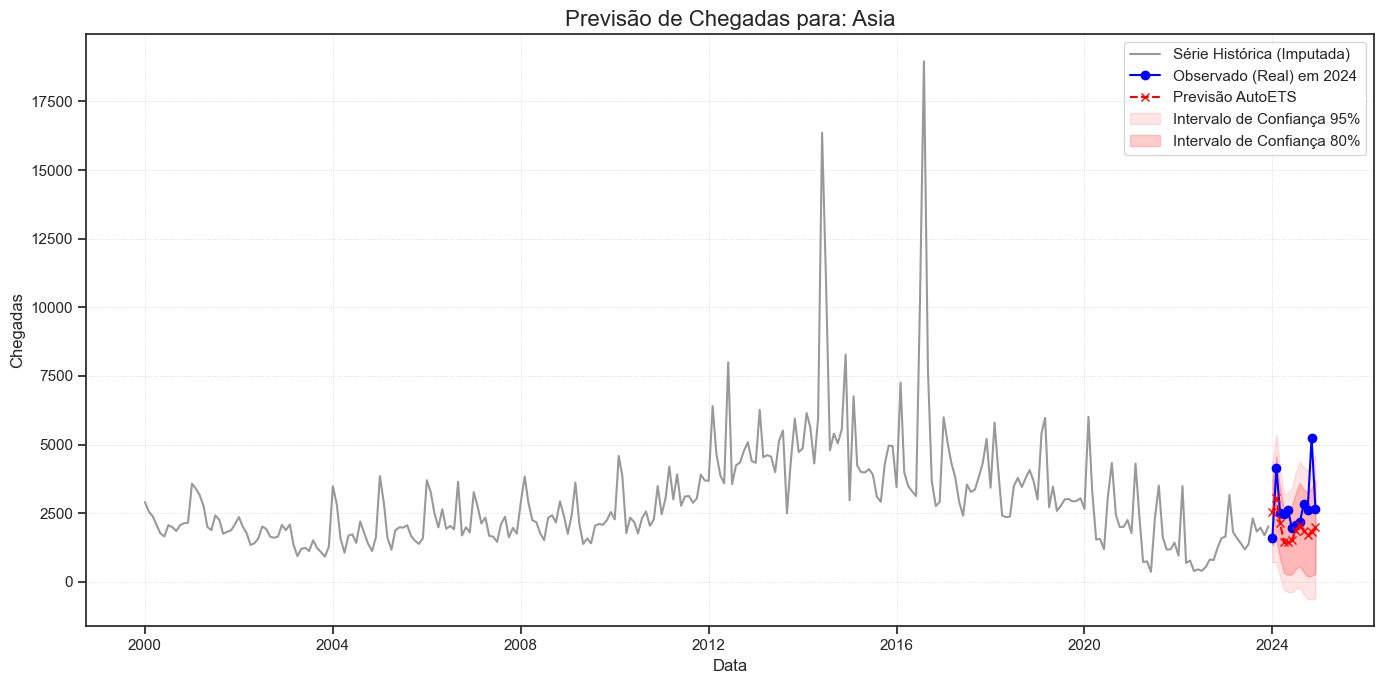

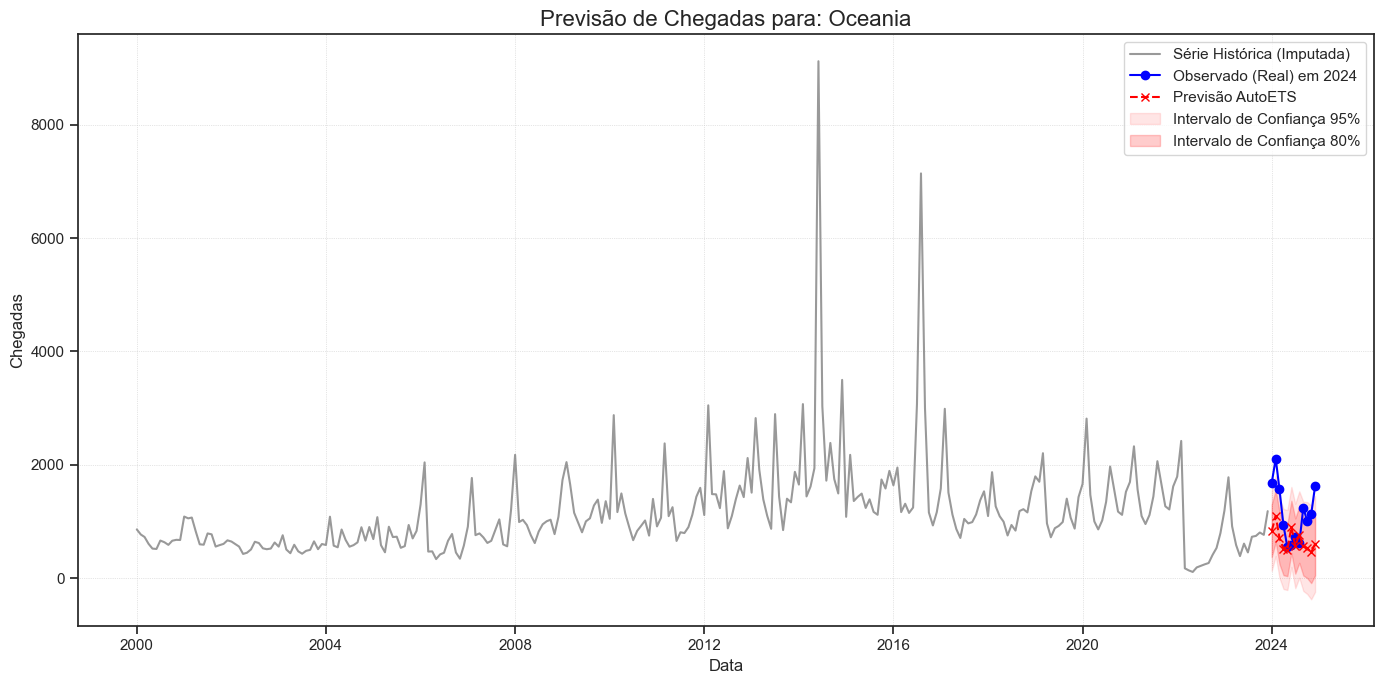

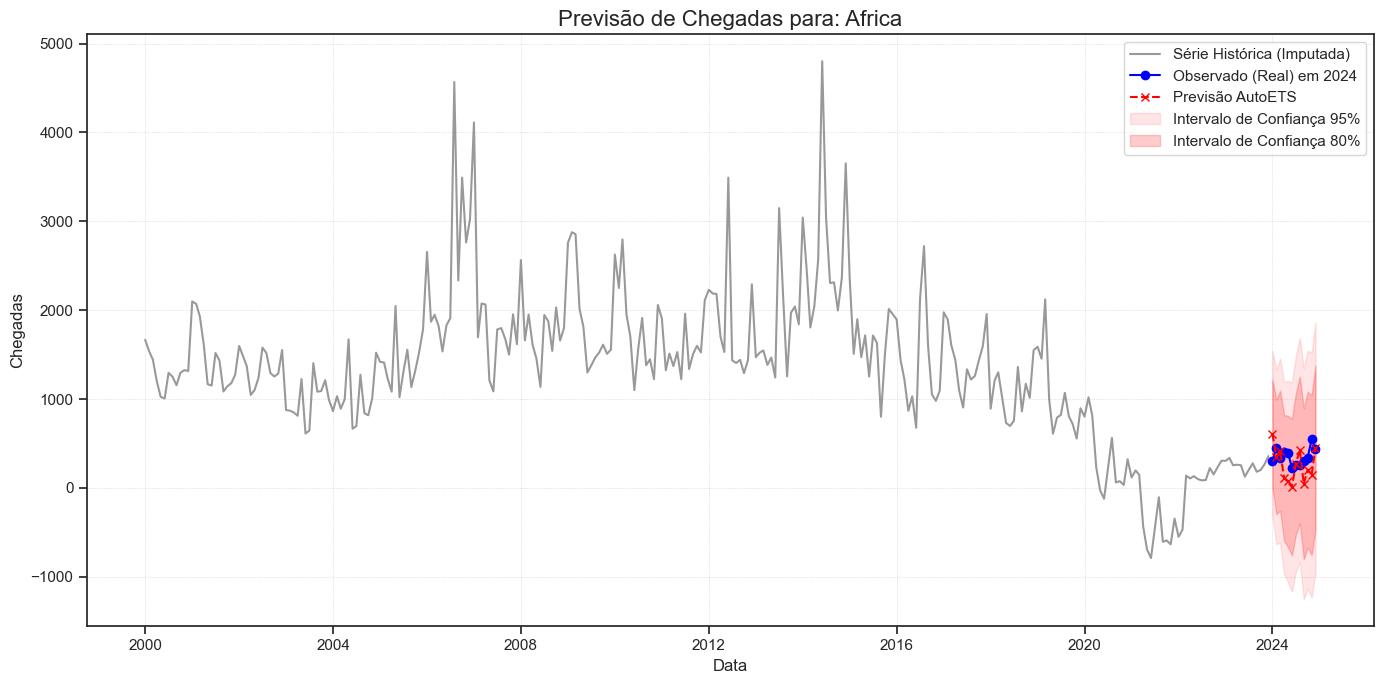

In [21]:
# Itera sobre os resultados para plotar cada previsão
for index, row in results_df.iterrows():
    continent_name = row['continent']
    forecast_df = row['forecast']
    
    # Pega a série original (não imputada) para comparação
    original_series = series_por_continente[continent_name]
    
    # Pega a série imputada para plotar o histórico completo
    imputed_series = imputed_continent_series[continent_name]

    if forecast_df is not None and not forecast_df.empty:
        plt.figure(figsize=(14, 7))
        
        # Plota a série histórica (imputada) até o final do treino
        plt.plot(imputed_series.loc[:train_end].index, imputed_series.loc[:train_end].values, 
                 label='Série Histórica (Imputada)', color='gray', alpha=0.8)

        # Plota a série original no período de teste para comparação
        test_period_original = original_series.loc[test_start:test_end]
        plt.plot(test_period_original.index, test_period_original.values, 
                 label='Observado (Real) em 2024', color='blue', marker='o', linestyle='-')
        
        # Plota a previsão
        plt.plot(forecast_df.index, forecast_df['AutoETS'], 
                 label='Previsão AutoETS', color='red', marker='x', linestyle='--')
        
        # Plota os intervalos de confiança, se existirem
        if 'AutoETS-lo-95' in forecast_df.columns and 'AutoETS-hi-95' in forecast_df.columns:
            plt.fill_between(forecast_df.index, 
                             forecast_df['AutoETS-lo-95'], 
                             forecast_df['AutoETS-hi-95'], 
                             color='red', alpha=0.1, label='Intervalo de Confiança 95%')
        if 'AutoETS-lo-80' in forecast_df.columns and 'AutoETS-hi-80' in forecast_df.columns:
            plt.fill_between(forecast_df.index, 
                             forecast_df['AutoETS-lo-80'], 
                             forecast_df['AutoETS-hi-80'], 
                             color='red', alpha=0.2, label='Intervalo de Confiança 80%')
        
        # Configurações do gráfico
        plt.title(f'Previsão de Chegadas para: {continent_name.replace("_", " ").title()}', fontsize=16)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Chegadas', fontsize=12)
        plt.legend()
        plt.grid(True, which='both', linestyle=':', linewidth=0.5)
        plt.tight_layout()
        plt.show()

--- Análise de Resíduos para: America_do_sul ---

Teste de Ljung-Box (lags=10): p-valor = 0.0166
  -> Conclusão: Há evidência de autocorrelação nos resíduos (p < 0.05).


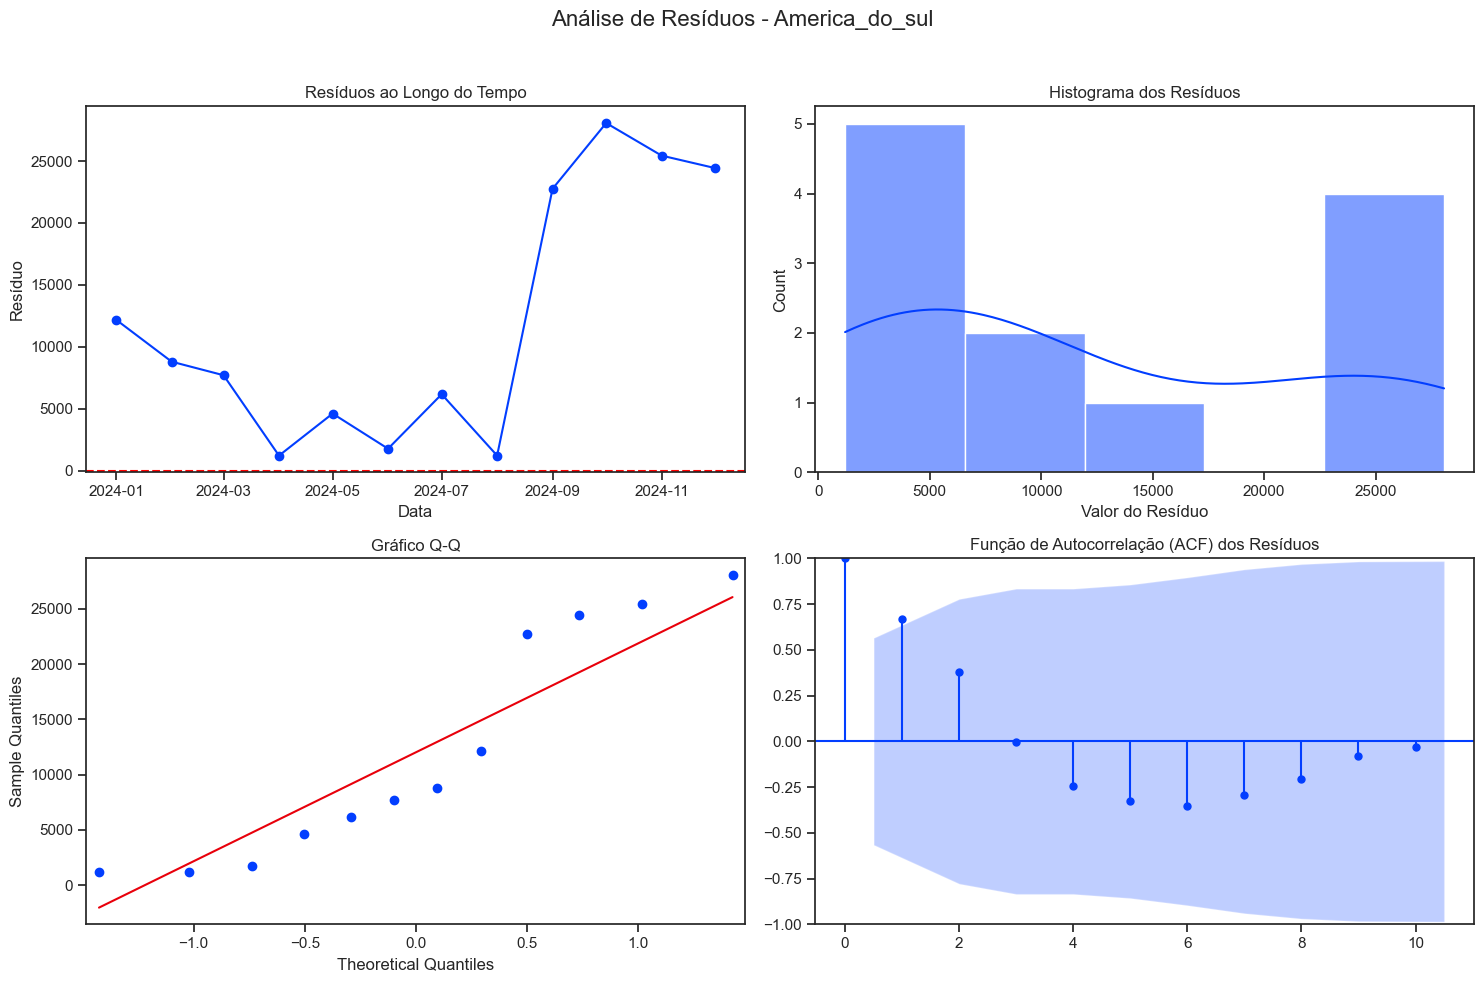

--- Análise de Resíduos para: Europa ---

Teste de Ljung-Box (lags=10): p-valor = 0.2212
  -> Conclusão: Não há evidência de autocorrelação nos resíduos (p >= 0.05).


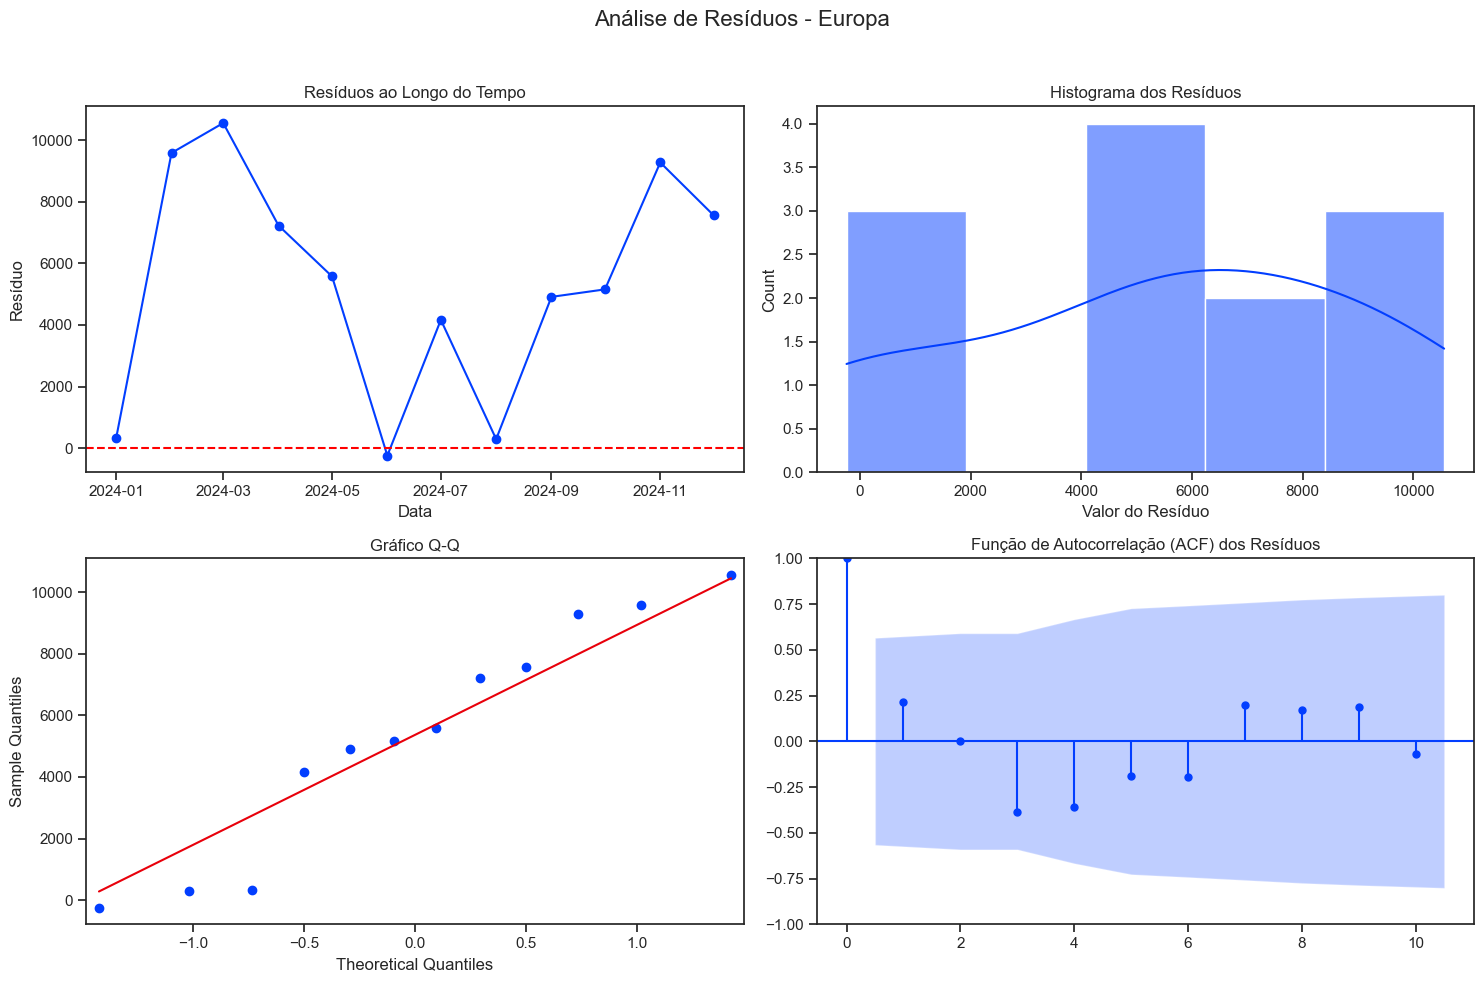

--- Análise de Resíduos para: America_do_norte ---

Teste de Ljung-Box (lags=10): p-valor = 0.1032
  -> Conclusão: Não há evidência de autocorrelação nos resíduos (p >= 0.05).


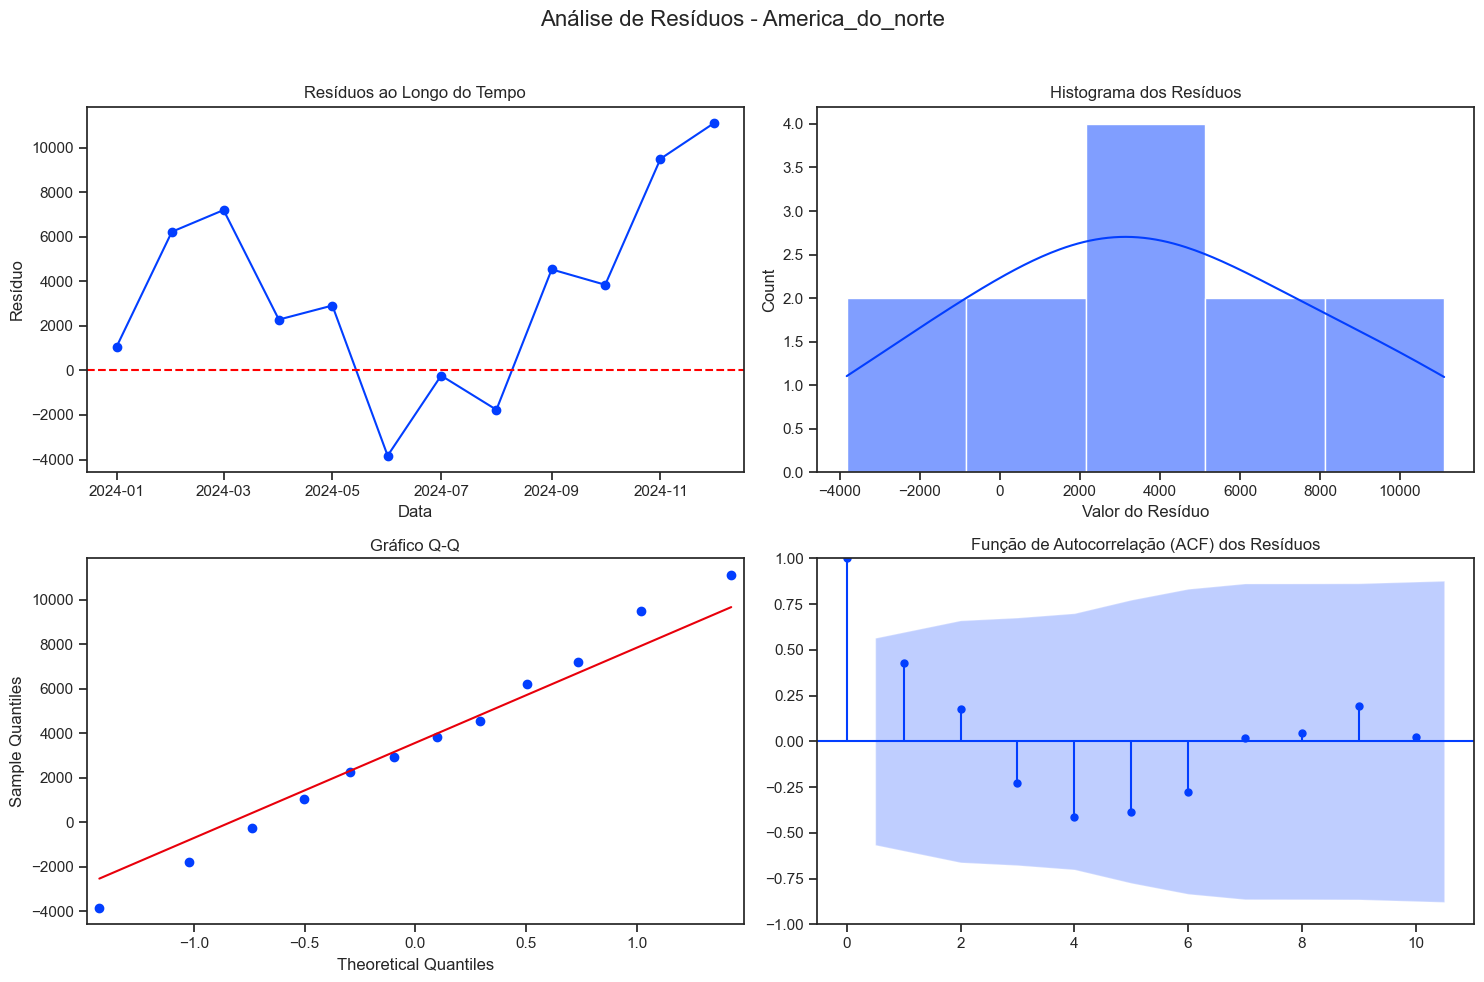

--- Análise de Resíduos para: America_central_e_caribe ---

Teste de Ljung-Box (lags=10): p-valor = 0.0034
  -> Conclusão: Há evidência de autocorrelação nos resíduos (p < 0.05).


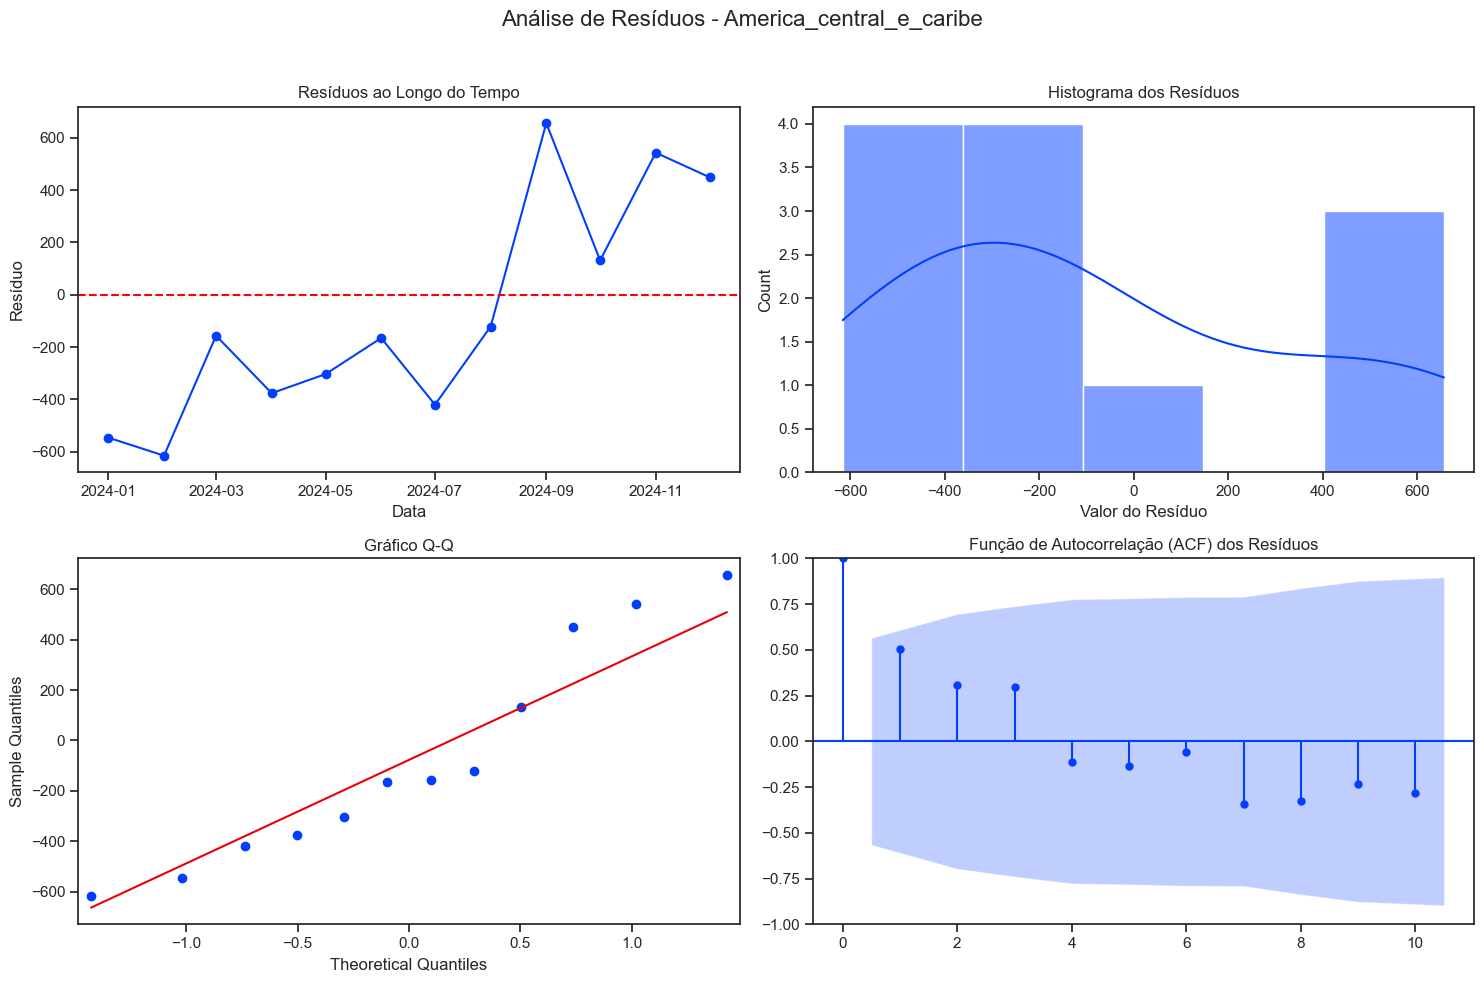

--- Análise de Resíduos para: Asia ---

Teste de Ljung-Box (lags=10): p-valor = 0.0630
  -> Conclusão: Não há evidência de autocorrelação nos resíduos (p >= 0.05).


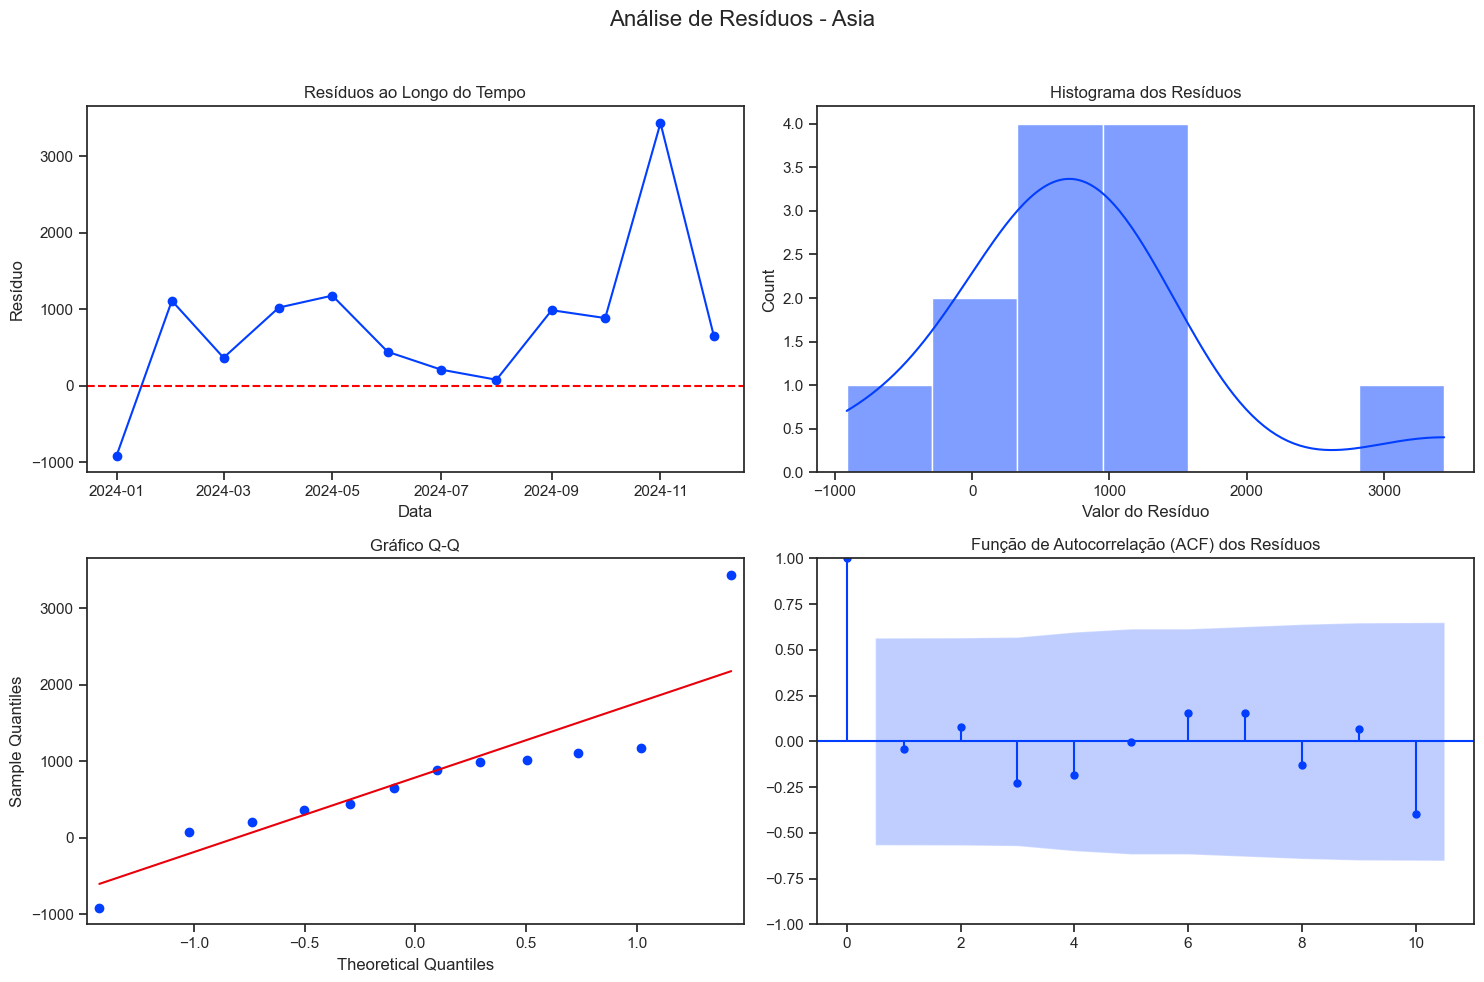

--- Análise de Resíduos para: Oceania ---

Teste de Ljung-Box (lags=10): p-valor = 0.0052
  -> Conclusão: Há evidência de autocorrelação nos resíduos (p < 0.05).


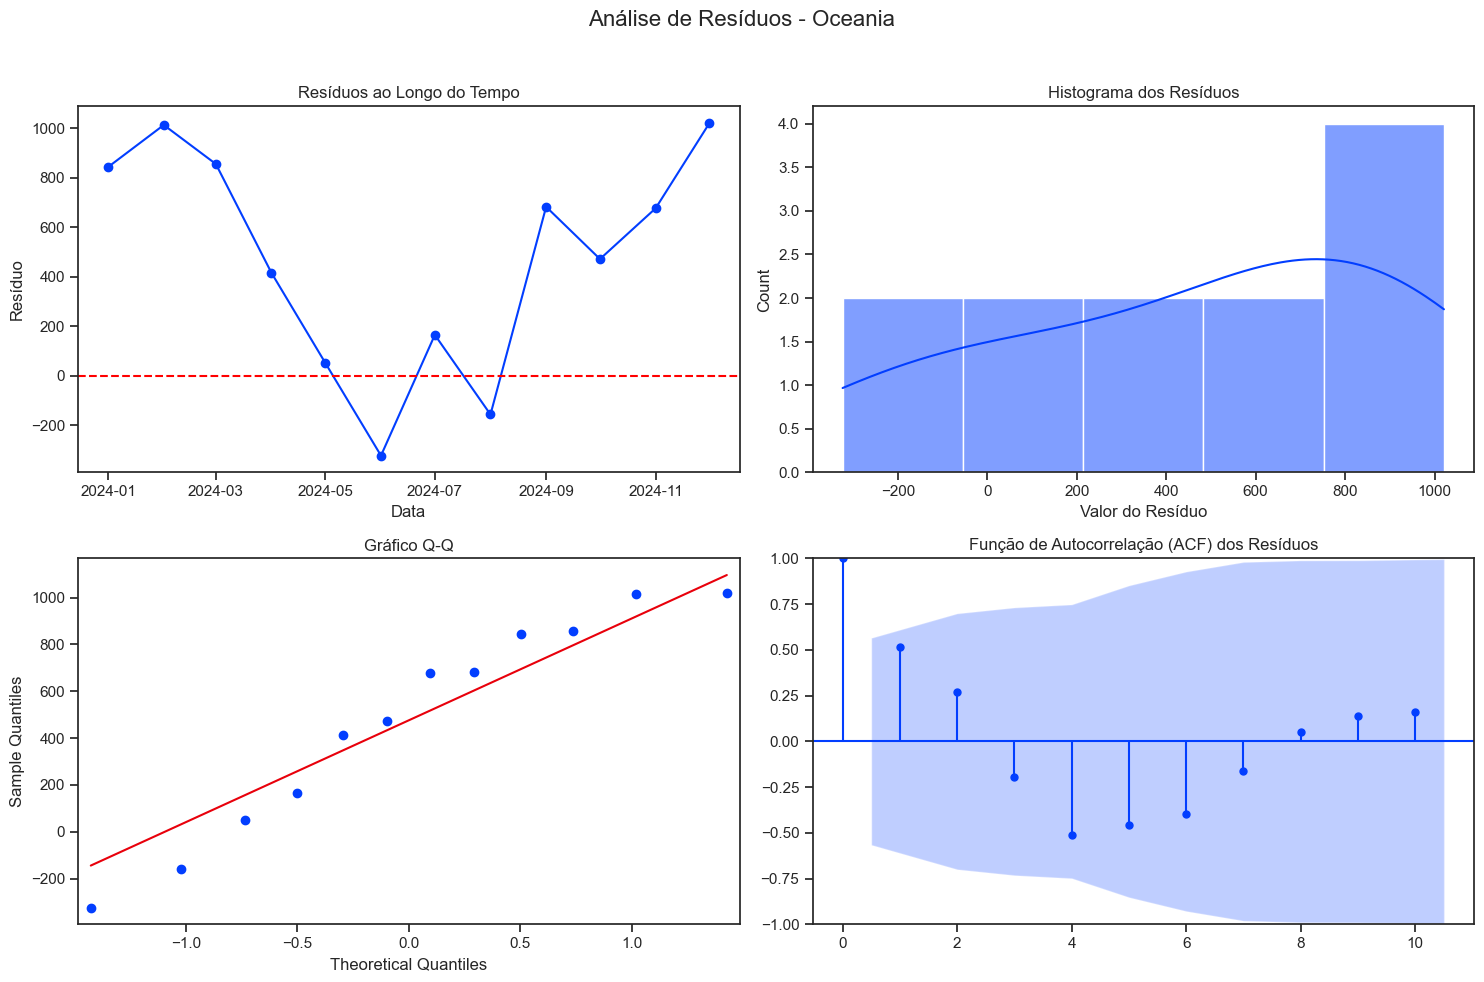

--- Análise de Resíduos para: Africa ---

Teste de Ljung-Box (lags=10): p-valor = 0.0695
  -> Conclusão: Não há evidência de autocorrelação nos resíduos (p >= 0.05).


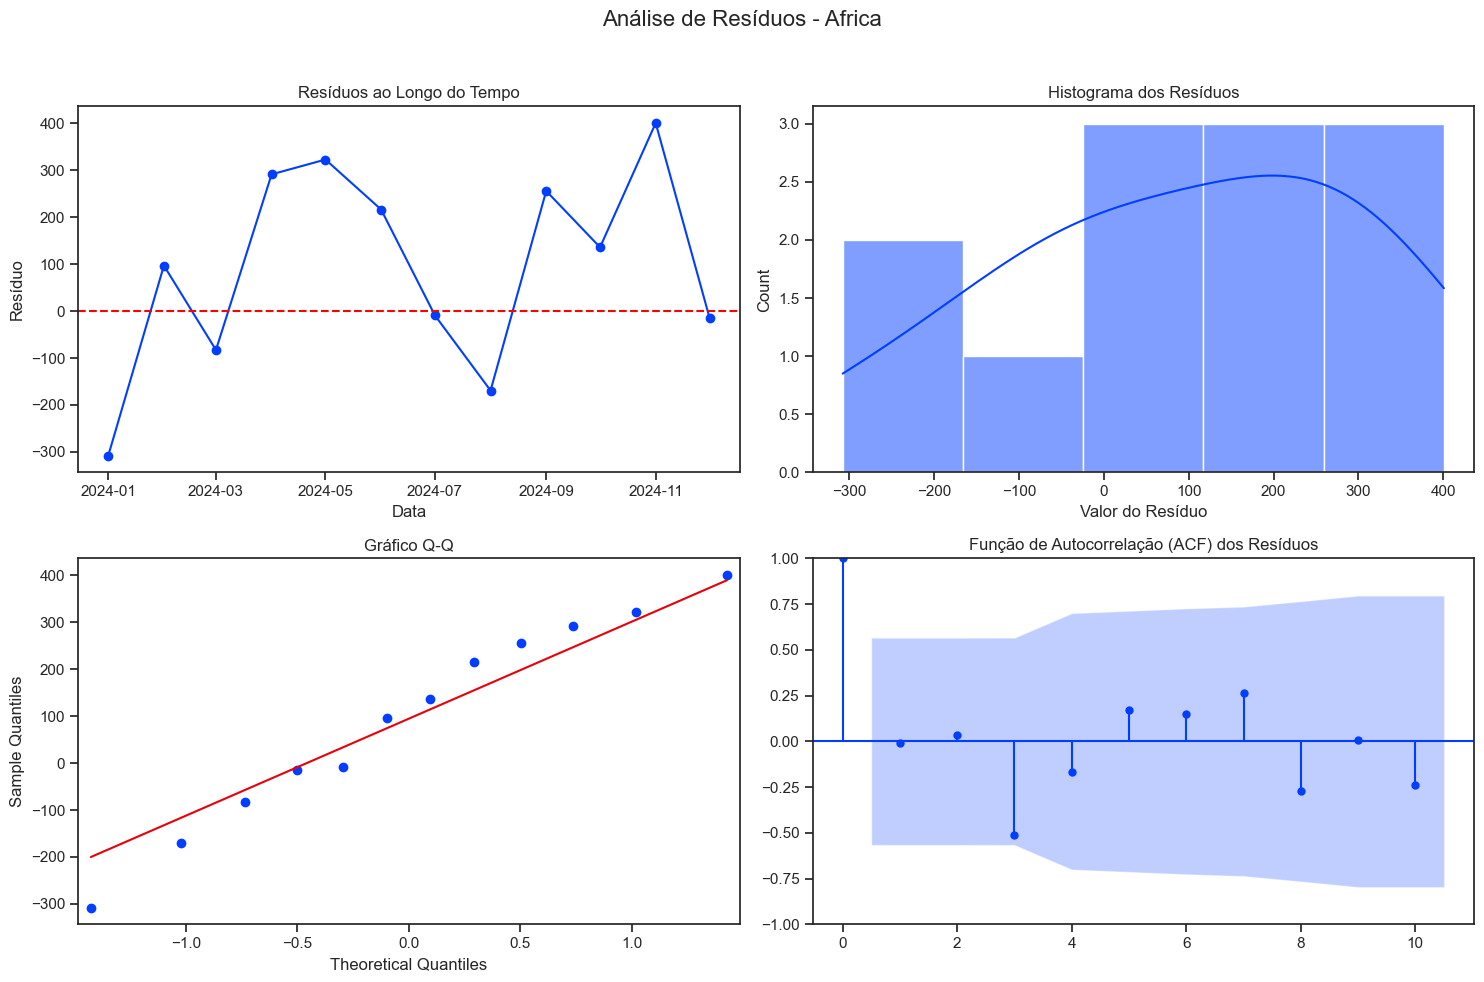

In [27]:
# Itera sobre os resultados para analisar os resíduos de cada previsão
for index, row in results_df.iterrows():
    continent_name = row['continent']
    forecast_data = row['forecast']  # forecast_data é um DataFrame
    
    if forecast_data is None or 'AutoETS' not in forecast_data.columns:
        print(f"Não há previsão para {continent_name}, pulando análise de resíduos.")
        continue

    # Extrai a série de previsão (a coluna 'AutoETS')
    forecast_series = forecast_data['AutoETS']

    # Pega a série original (não imputada) para o período de teste
    original_series_test = series_por_continente[continent_name].loc[test_start:test_end]
    
    # Calcula os resíduos
    # Garante que ambos os índices estão alinhados antes da subtração
    residuals = original_series_test - forecast_series.reindex(original_series_test.index)
    
    print(f"--- Análise de Resíduos para: {continent_name.capitalize()} ---")
    
    # Cria uma figura com 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Análise de Resíduos - {continent_name.capitalize()}', fontsize=16)
    
    # 1. Plot dos resíduos ao longo do tempo
    axes[0, 0].plot(residuals.index, residuals.values, marker='o', linestyle='-')
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_title('Resíduos ao Longo do Tempo')
    axes[0, 0].set_xlabel('Data')
    axes[0, 0].set_ylabel('Resíduo')
    
    # 2. Histograma dos resíduos
    sns.histplot(residuals.dropna(), kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Histograma dos Resíduos')
    axes[0, 1].set_xlabel('Valor do Resíduo')
    
    # 3. Gráfico Q-Q (Quantil-Quantil)
    sm.qqplot(residuals.dropna(), line='s', ax=axes[1, 0])
    axes[1, 0].set_title('Gráfico Q-Q')
    
    # 4. Gráfico de Autocorrelação (ACF)
    clean_residuals = residuals.dropna()
    if len(clean_residuals) > 1:
        sm.graphics.tsa.plot_acf(clean_residuals, ax=axes[1, 1], lags=min(10, len(clean_residuals)-1))
    axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

    # 5. Teste de Ljung-Box para autocorrelação
    if len(clean_residuals) > 1:
        # O número de lags deve ser menor que o número de observações
        lags = min(10, len(clean_residuals) - 1)
        if lags > 0:
            # Acessa o p-valor corretamente a partir do DataFrame retornado
            ljung_box_result = sm.stats.acorr_ljungbox(clean_residuals, lags=[lags], return_df=True)
            lb_pvalue = ljung_box_result.iloc[0]['lb_pvalue']

            print(f"\nTeste de Ljung-Box (lags={lags}): p-valor = {lb_pvalue:.4f}")
            if lb_pvalue < 0.05:
                print("  -> Conclusão: Há evidência de autocorrelação nos resíduos (p < 0.05).")
            else:
                print("  -> Conclusão: Não há evidência de autocorrelação nos resíduos (p >= 0.05).")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


ETS no R, com dataset original

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
ro.r('library(forecast)')
ro.r('library(stats)')

In [10]:
with localconverter(ro.default_converter + pandas2ri.converter):
    df_r = ro.conversion.py2rpy(data_series)

serie_temporal_r = ro.r.ts(df_r, 
                                start=[2000,1], 
                                frequency=12)

print(serie_temporal_r)

treino = ro.r.head(serie_temporal_r, n=-12)

modelo_ets = ro.r.ets(treino)

previsao_r = ro.r.forecast(modelo_ets, h=12)





# Converte o objeto R 'previsao_r' para um DataFrame pandas
with localconverter(ro.default_converter + pandas2ri.converter):
    mean = ro.conversion.rpy2py(previsao_r.rx2('mean'))      # previsões pontuais
    lower = ro.conversion.rpy2py(previsao_r.rx2('lower'))    # limites inferiores (matriz)
    upper = ro.conversion.rpy2py(previsao_r.rx2('upper'))    # limites superiores (matriz)
    levels = list(previsao_r.rx2('level'))                   # níveis de confiança (ex: [80,95])

# Garante que lower/upper tenham duas dimensões
lower = np.atleast_2d(lower)
upper = np.atleast_2d(upper)

# Cria índice de datas para o horizonte de previsão a partir da última data dos dados (df_ets)
last_date = pd.Timestamp('2023-12-01')
start = last_date + pd.offsets.MonthBegin(1)
periods = len(mean)
idx = pd.date_range(start=start, periods=periods, freq='MS')

# Monta o DataFrame final com colunas para média e intervalos de confiança
forecast_df = pd.DataFrame({'ds': idx, 'forecast': mean})
for i, lvl in enumerate(levels):
    forecast_df[f'lower_{int(lvl)}'] = lower[:, i]
    forecast_df[f'upper_{int(lvl)}'] = upper[:, i]



        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2000  91318  80424  75716  62957  53855  52278  67061  64874  59626  66774
2001 114615 107891 100995  84549  61234  59574  78543  73986  56266  58872
2002  73318  66973  61748  47035  49495  55748  70877  68161  57979  56317
2003  76971  70003  67437  57416  44763  43701  52658  55955  50309  52607
2004  88969  86045  76117  67457  48664  47301  58762  62802  56422  60496
2005 105732  91165  79298  59718  57254  56667  83108  60832  53960  68175
2006 109025  98499  81265  64811  53855  51338  53730  47428  46483  52905
2007  93770  84175  68420  62934  48396  51953  67885  62353  55140  54949
2008  93335  87134  88747  55426  48925  48328  60618  60773  53170  51225
2009 104561  91448 104937  75300  59395  54564  59949  72893  60702  68274
2010  96660 109875 115466  69266  56915  55296  69000  76722  69072  77160
2011 100232 113131 114213  82379  64714  59397  74229  70459  66987  82986
2012 107029 121752 129423

ETS no R, com versão imputada

In [11]:
with localconverter(ro.default_converter + pandas2ri.converter):
    df_ri = ro.conversion.py2rpy(data_series_imputada)

serie_temporal_ri = ro.r.ts(df_ri, 
                                start=[2000,1], 
                                frequency=12)

treinoi = ro.r.head(serie_temporal_ri, n=-12)

modelo_etsi = ro.r.ets(treinoi)

previsao_ri = ro.r.forecast(modelo_etsi, h=12)

with localconverter(ro.default_converter + pandas2ri.converter):
    mean = ro.conversion.rpy2py(previsao_ri.rx2('mean'))      # previsões pontuais
    lower = ro.conversion.rpy2py(previsao_ri.rx2('lower'))    # limites inferiores (matriz)
    upper = ro.conversion.rpy2py(previsao_ri.rx2('upper'))    # limites superiores (matriz)
    levels = list(previsao_ri.rx2('level'))                   # níveis de confiança (ex: [80,95])

# Garante que lower/upper tenham duas dimensões
lower = np.atleast_2d(lower)
upper = np.atleast_2d(upper)

# Cria índice de datas para o horizonte de previsão a partir da última data dos dados (df_ets)
last_date = pd.Timestamp('2023-12-31')
start = last_date + pd.offsets.MonthBegin(1)
periods = len(mean)
idx = pd.date_range(start=start, periods=periods, freq='MS')

# Monta o DataFrame final com colunas para média e intervalos de confiança
forecast_dfi = pd.DataFrame({'ds': idx, 'forecast': mean})
for i, lvl in enumerate(levels):
    forecast_dfi[f'lower_{int(lvl)}'] = lower[:, i]
    forecast_dfi[f'upper_{int(lvl)}'] = upper[:, i]



In [12]:
forecast_dates = pd.to_datetime(forecast_df['ds'])
y_pred = forecast_df['forecast'].values
y_predi = forecast_dfi['forecast'].values
y_true = data_series.reindex(forecast_dates).values  # alinha pelos índices de data

# Retorna tabela comparativa para inspeção
comparison = pd.DataFrame({'ds': forecast_dates, 'y_true': y_true, 'y_pred': y_pred, 'y_predi': y_predi}).set_index('ds')
comparison

,y_true,y_pred,y_predi
ds,,,
2024-01-01,163598.0,144968.304603,144482.607359
2024-02-01,170305.0,126521.926030,139417.386887
2024-03-01,157683.0,111490.348927,128083.595380
2024-04-01,102172.0,78863.241239,94220.894420
2024-05-01,84116.0,60233.032259,74246.324751
2024-06-01,82402.0,73630.857630,89422.269346
2024-07-01,108089.0,82625.034570,105806.591779
2024-08-01,91504.0,76752.918345,100906.641979
2024-09-01,116003.0,67291.470683,87691.226682


Plot dos valores observados vs previstos e cálculo de MAPE e RMSE

RMSE: 34948.11
MAPE: 24.94%
RMSEi: 25754.56
MAPEi: 15.95%


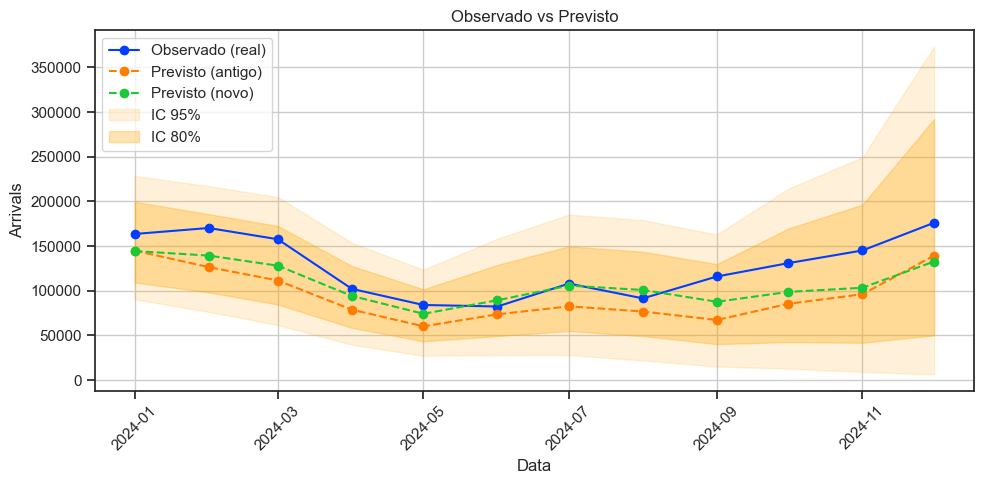

In [14]:
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE
mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE em %

rmse_vali = np.sqrt(mean_squared_error(y_true, y_predi))  # RMSE
mape_vali = mean_absolute_percentage_error(y_true, y_predi) * 100

print(f"RMSE: {rmse_val:.2f}")
print(f"MAPE: {mape_val:.2f}%")

print(f"RMSEi: {rmse_vali:.2f}")
print(f"MAPEi: {mape_vali:.2f}%")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(comparison.index, y_true, label="Observado (real)", marker="o")
plt.plot(comparison.index, y_pred, label="Previsto (antigo)", marker="o", linestyle="--")
plt.plot(comparison.index, y_predi, label="Previsto (novo)", marker="o", linestyle="--")
# Plota intervalos de confiança (95% e 80%) usando as colunas já calculadas em forecast_df
plt.fill_between(comparison.index, forecast_dfi['lower_95'].values, forecast_df['upper_95'].values,
                 color='orange', alpha=0.15, label='IC 95%')
plt.fill_between(comparison.index, forecast_dfi['lower_80'].values, forecast_df['upper_80'].values,
                 color='orange', alpha=0.30, label='IC 80%')
plt.xlabel("Data")
plt.ylabel("Arrivals")
plt.title("Observado vs Previsto")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()